# Riluzole Study Biomarkers

In [1]:
# install required packages - commented out so it doesn't install every time
#%conda install -n Lauren openpyxl numpy pandas statsmodels plotnine matplotlib scikit-learn scipy mizani nbconvert pandoc pyreadstat kmodes seaborn

# import required packages
import openpyxl; 
import datetime;
import numpy as np;
import pandas as pd;
import statsmodels as sm;
import statsmodels.formula.api as smf;
import plotnine as p9;
import matplotlib;
#import sklearn;
import scipy;
from scipy.stats import linregress;
from scipy.stats import pearsonr;
import itertools
from sklearn import preprocessing 
import inspect
import pickle

import warnings
warnings.filterwarnings('ignore')

C:\Users\Lauren.Koenig\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# read in and clean data

In [2]:
data_loc = "//admsyn/Primary/ADM/CustomerStudies/Rockefeller/Riluzole_Biomarkers/"
code_loc = "//admsyn/homes/@DH-ADMDX/0/lauren.koenig-1606/code/Riluzole FDG/"

In [3]:
# read in data
biomarker_relationship_results_log10, biomarker_relationship_results_raw, all_data = pd.read_pickle(code_loc + 'output/03_data.pkl')

In [4]:
# make data subsets
placebo_data = all_data[all_data['Group'].isin(['Placebo'])]
baseline_data = all_data[all_data['Group2'].isin(['Riluzole Trial Participants']) & all_data['timepoint'].isin(['base'])]
placebo_baseline_data = all_data[(all_data['Group2'].isin(['Riluzole Trial Participants']) & all_data['timepoint'].isin(['base']) ) | all_data['Group'].isin(['Placebo'])]

placebo_data_70_80 = placebo_data[(placebo_data['age']<=80) & (placebo_data['age']>=70)]
baseline_data_70_80 = baseline_data[(baseline_data['age']<=80) & (baseline_data['age']>=70)]

In [5]:
# define biomarker groups
FDG_columns = ['AC_gm','Avg_Hip','R_Hip', 'L_Hip', 'Avg_MedOrbFrontal', 'Avg_PCC', 'FRONTAL_gm', 'MTL_gm',  'Par_gm', 'PostCing_gm', 'Precun_gm', 'Temp', 'Temp_gm','CV1']
FDG_columns_pons = ['Temp_gm_ponsref', 'MTL_gm_ponsref', 'PostCing_gm_ponsref', 'Par_gm_ponsref', 'Precun_gm_ponsref', 'AC_gm_ponsref']
FDG_columns_para2 = ['Temp_gm_refpara2', 'MTL_gm_refpara2', 'PostCing_gm_refpara2', 'Par_gm_refpara2', 'Precun_gm_refpara2', 'AC_gm_refpara2', 'Avg_PCC_refpara2']

plasma_columns = [ 'Ab40', 'Ab42', 'Ab42_40', 'GFAP','NFL',  'pTau181', 'pTau217',  'pTau231', 'pTau181_Ab42']
log10_plasma_columns = [s + '_log10' for s in plasma_columns]

cog_columns = ['Screening_MMSE', 'adascogtotal', 'bvrt', 'dstotal','tma','tmb',  'cowattotal', 'cdrtotal', 'cdrsum', 'adltotal', 'npitotal']

vol_columns = ['VOL_Precun_Lz', 'VOL_Precun_Rz', 'VOL_InfPar_Lz', 'VOL_InfPar_Rz', 'VOL_Hip_Lz', 'VOL_Hip_Rz', 'VOL_TotalGrayz', 'VOL_Inf_Mid_Fus_Temp_Lz', 
'VOL_Inf_Mid_Fus_Temp_Rz','VOL__MidFront_Lz', 'VOL_MidFront_Rz']

In [6]:
baseline_data[log10_plasma_columns].notna().sum(axis = 0)

Ab40_log10            35
Ab42_log10            31
Ab42_40_log10         31
GFAP_log10            37
NFL_log10             37
pTau181_log10         37
pTau217_log10         34
pTau231_log10         33
pTau181_Ab42_log10    31
dtype: int64

In [7]:
baseline_data[FDG_columns].notna().sum(axis = 0)

AC_gm                41
Avg_Hip              41
R_Hip                41
L_Hip                41
Avg_MedOrbFrontal    41
Avg_PCC              41
FRONTAL_gm           41
MTL_gm               41
Par_gm               41
PostCing_gm          41
Precun_gm            41
Temp                 41
Temp_gm              41
CV1                  41
dtype: int64

In [8]:
baseline_data[cog_columns].notna().sum(axis = 0)

Screening_MMSE    41
adascogtotal      41
bvrt              40
dstotal           41
tma               38
tmb               20
cowattotal        41
cdrtotal          41
cdrsum            41
adltotal          41
npitotal          41
dtype: int64

In [9]:
baseline_data[vol_columns].notna().sum(axis = 0)

VOL_Precun_Lz              34
VOL_Precun_Rz              34
VOL_InfPar_Lz              34
VOL_InfPar_Rz              34
VOL_Hip_Lz                 34
VOL_Hip_Rz                 34
VOL_TotalGrayz             34
VOL_Inf_Mid_Fus_Temp_Lz    34
VOL_Inf_Mid_Fus_Temp_Rz    34
VOL__MidFront_Lz           34
VOL_MidFront_Rz            34
dtype: int64

In [10]:
baseline_data['MMSE_bin'] = pd.qcut(baseline_data['Screening_MMSE'], [0, .25, .75, 1.], precision = 2).astype('str')
baseline_data['cdrsum_bin'] = pd.qcut(baseline_data['cdrsum'], [0, .25, .75, 1.], precision = 2).astype('str')
baseline_data['Ab42_40_log10_bin'] = pd.qcut(baseline_data['Ab42_40'], [0, .25, .75, 1.], precision = 2).astype('str')
baseline_data['pTau217_log10_bin'] = pd.qcut(baseline_data['pTau217'], [0, .25, .75, 1.], precision = 2).astype('str')
baseline_data['GFAP_log10_bin'] = pd.qcut(baseline_data['GFAP'], [0, .25, .75, 1.], precision = 2).astype('str')
baseline_data['NFL_log10_bin'] = pd.qcut(baseline_data['NFL'], [0, .25, .75, 1.], precision = 2).astype('str')
baseline_data['VOL_Hip_Rz_bin'] = pd.qcut(baseline_data['VOL_Hip_Rz'], [0, .25, .75, 1.], precision = 2).astype('str')

In [11]:
graphing_p = 0.05
pvals_to_consider = ['lin_multi_p_baseline']
Bval_to_grab = 'lin_multi_B_baseline'

# pTau interrelationships

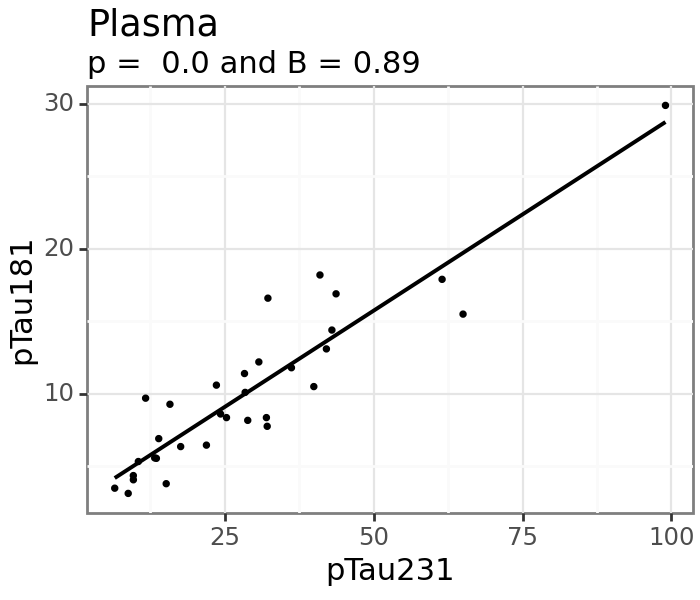

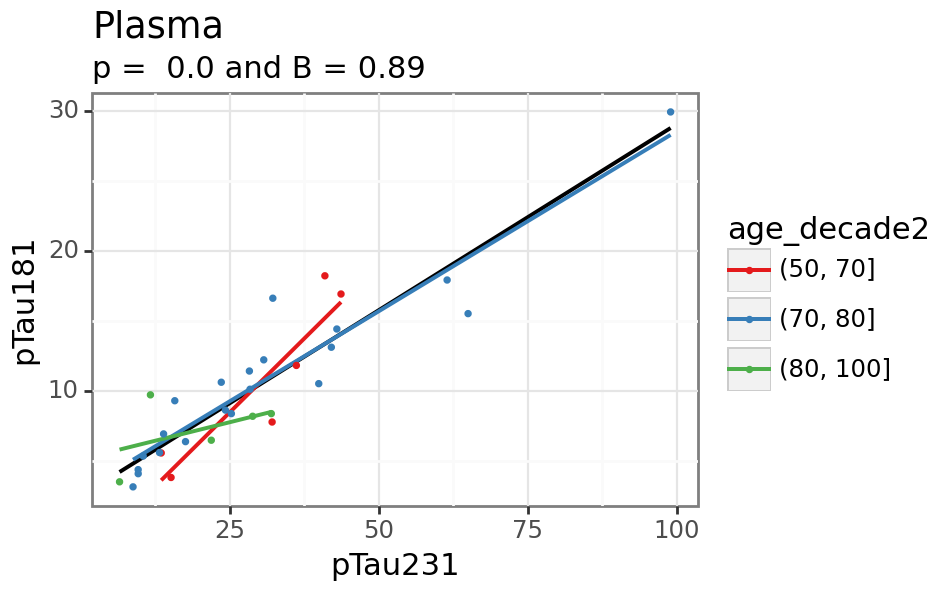

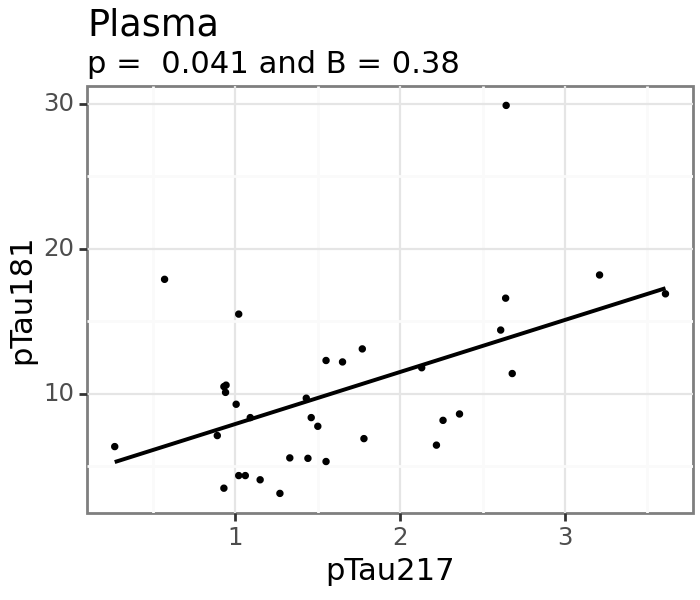

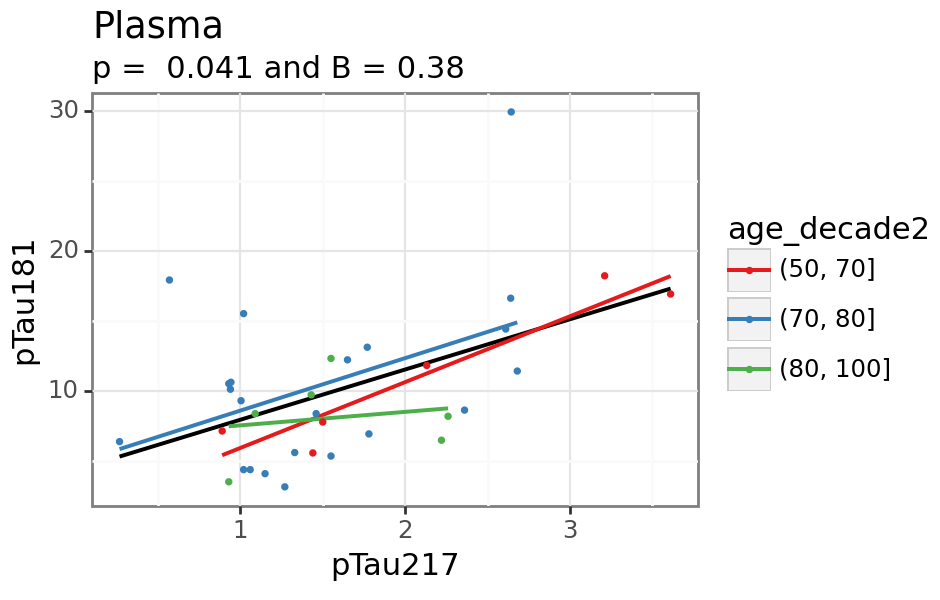

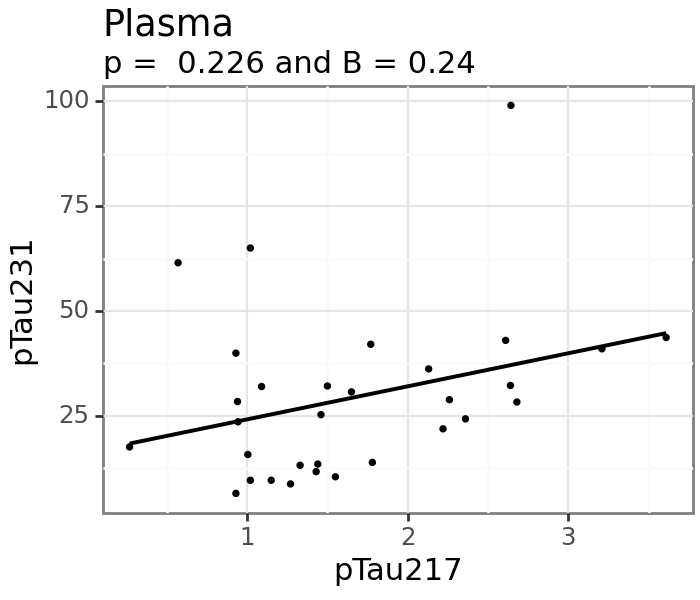

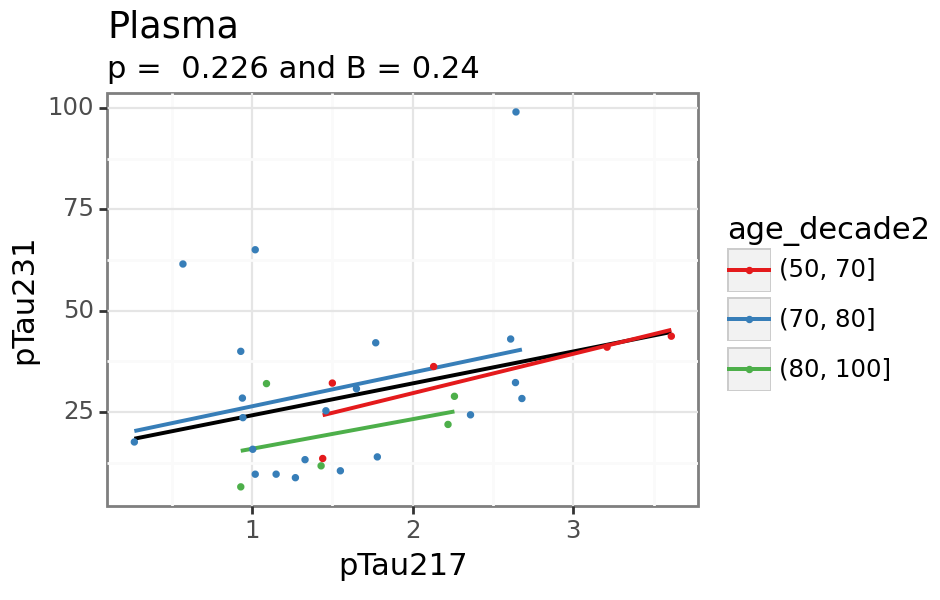

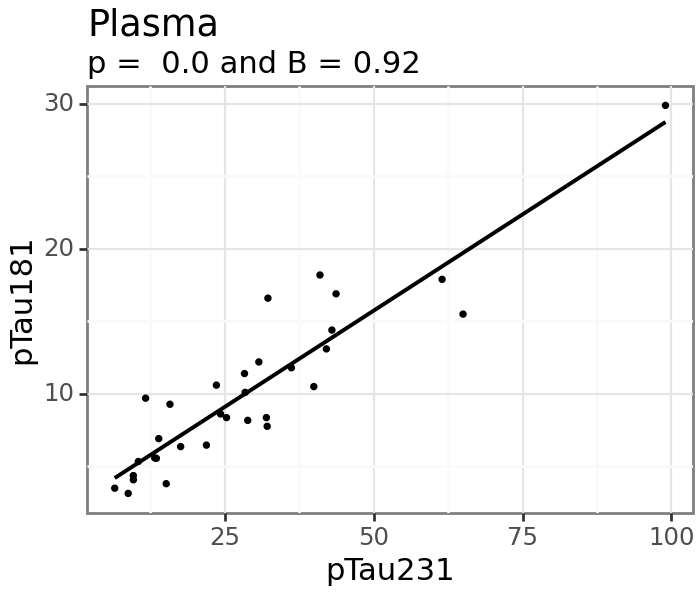

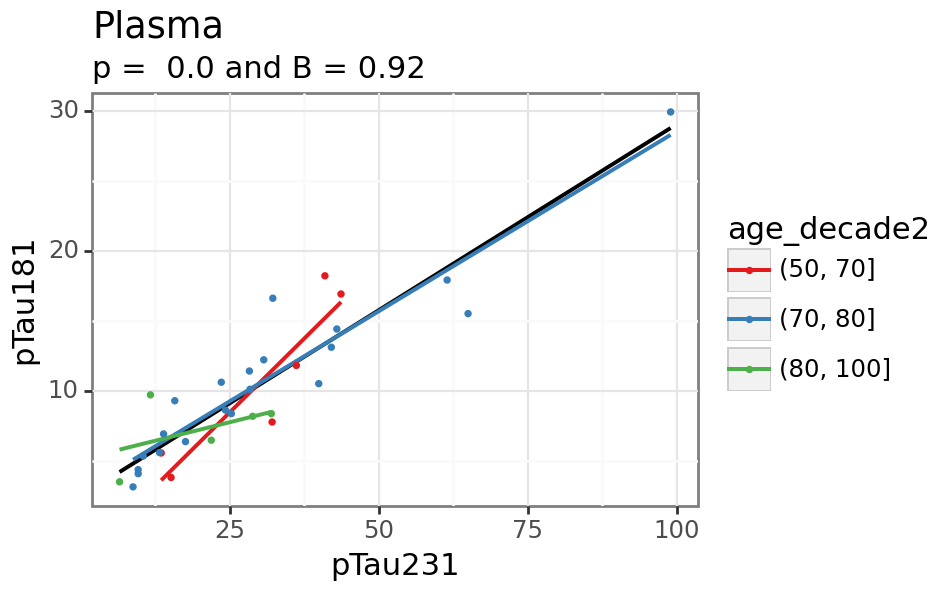

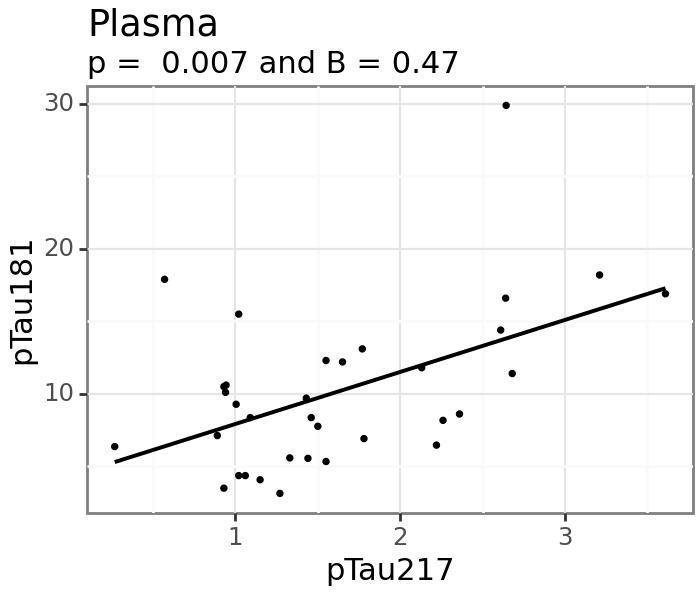

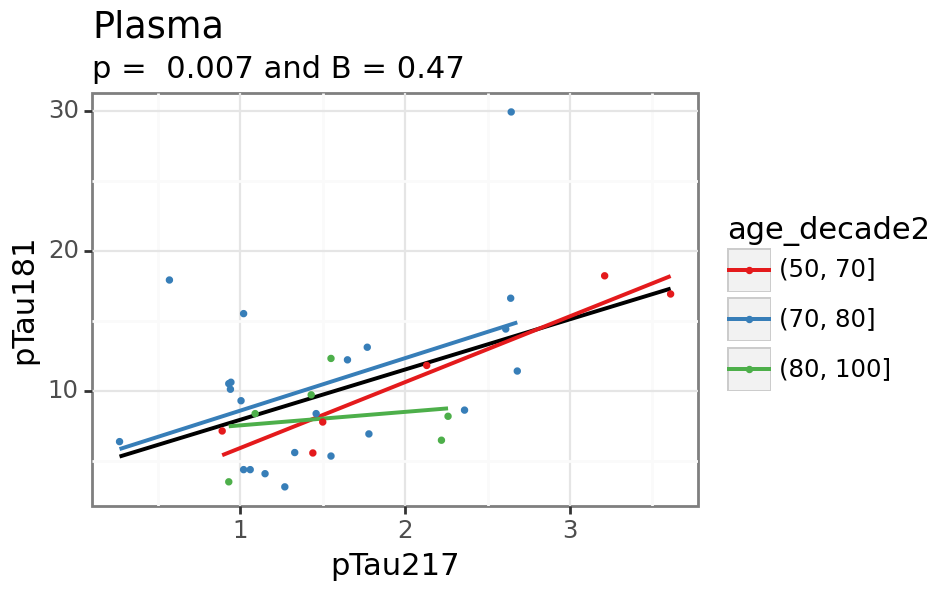

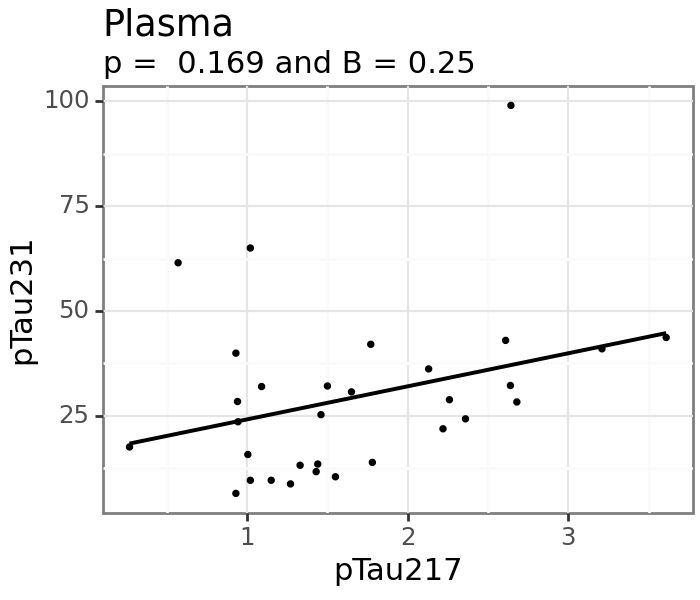

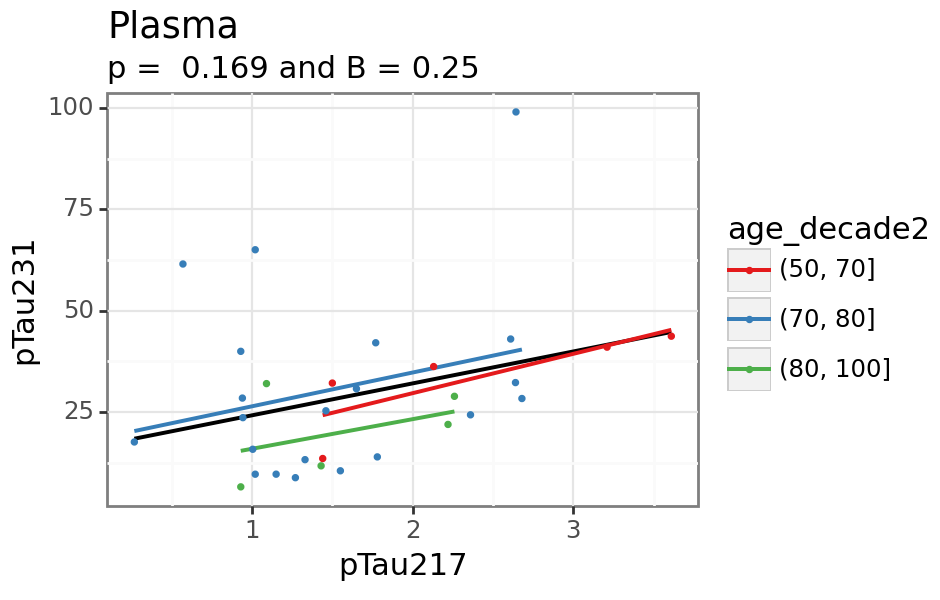

In [12]:
combinations = pd.DataFrame(list(itertools.combinations(['pTau181', 'pTau231', 'pTau217'], 2)))
for idx in range(combinations[0].size):
    var = combinations[1][idx]
    var1 = combinations[0][idx]
    p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), pvals_to_consider[0]].reset_index(drop=True)[0].round(3).astype('str')
    B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')

    var0 = var
    subset_data = baseline_data.dropna(subset = [var0, var1])
    subset_data2 = subset_data.copy()
    subset_data2 = subset_data2.groupby('age_decade2', observed=True).filter(lambda x: x['ID_ADM'].nunique()> 4)
    p9.options.figure_size = (3.5,3)    
    plot = (
            p9.ggplot(subset_data, p9.aes(x = var0, y = var1))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(subset_data, size = 0.8, se = False, alpha = 1, color = 'black', method = 'lm')
            + p9.geom_line(p9.aes(group = 'ID_ADM'), size = 0.2, linetype = '--')
            + p9.geom_point(size = 0.5)
            + p9.labs(subtitle = ('p =  ' + p_value + ' and B = ' + B_value), title = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), 'type'].reset_index(drop=True)[0])
            + p9.scale_color_brewer(type="qual", palette="Set1")
            + p9.theme(legend_position='none')
        )
    print(plot)

    p9.options.figure_size = (4.7,3)    
    plot = (
            p9.ggplot(subset_data, p9.aes(x = var0, y = var1, color = 'age_decade2'))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(subset_data, size = 0.8, se = False, alpha = 1, color = 'black', method = 'lm')
            + p9.geom_smooth(subset_data2, size = 0.8, se = False, alpha = 1, method = 'lm')
            + p9.geom_line(p9.aes(group = 'ID_ADM'), size = 0.2, linetype = '--')
            + p9.geom_point(size = 0.5)
            + p9.labs(subtitle = ('p =  ' + p_value + ' and B = ' + B_value), title = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), 'type'].reset_index(drop=True)[0])
            + p9.scale_color_brewer(type="qual", palette="Set1")
            + p9.theme()
        )
    print(plot)

combinations = pd.DataFrame(list(itertools.combinations(['pTau181', 'pTau231', 'pTau217'], 2)))
for idx in range(combinations[0].size):
    var = combinations[1][idx]
    var1 = combinations[0][idx]
    p_value = biomarker_relationship_results_raw.loc[biomarker_relationship_results_raw['var1'].isin([var]) & biomarker_relationship_results_raw['var2'].isin([var1]), pvals_to_consider[0]].reset_index(drop=True)[0].round(3).astype('str')
    B_value = biomarker_relationship_results_raw.loc[biomarker_relationship_results_raw['var1'].isin([var]) & biomarker_relationship_results_raw['var2'].isin([var1]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')

    var0 = var
    subset_data = baseline_data.dropna(subset = [var0, var1])
    subset_data2 = subset_data.copy()
    subset_data2 = subset_data2.groupby('age_decade2', observed=True).filter(lambda x: x['ID_ADM'].nunique()> 4)
    p9.options.figure_size = (3.5,3)    
    plot = (
            p9.ggplot(subset_data, p9.aes(x = var0, y = var1))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(subset_data, size = 0.8, se = False, alpha = 1, color = 'black', method = 'lm')
            + p9.geom_line(p9.aes(group = 'ID_ADM'), size = 0.2, linetype = '--')
            + p9.geom_point(size = 0.5)
            + p9.labs(subtitle = ('p =  ' + p_value + ' and B = ' + B_value), title = biomarker_relationship_results_raw.loc[biomarker_relationship_results_raw['var1'].isin([var]) & biomarker_relationship_results_raw['var2'].isin([var1]), 'type'].reset_index(drop=True)[0])
            + p9.scale_color_brewer(type="qual", palette="Set1")
            + p9.theme(legend_position='none')
        )
    print(plot)

    p9.options.figure_size = (4.7,3)    
    plot = (
            p9.ggplot(subset_data, p9.aes(x = var0, y = var1, color = 'age_decade2'))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(subset_data, size = 0.8, se = False, alpha = 1, color = 'black', method = 'lm')
            + p9.geom_smooth(subset_data2, size = 0.8, se = False, alpha = 1, method = 'lm')
            + p9.geom_line(p9.aes(group = 'ID_ADM'), size = 0.2, linetype = '--')
            + p9.geom_point(size = 0.5)
            + p9.labs(subtitle = ('p =  ' + p_value + ' and B = ' + B_value), title = biomarker_relationship_results_raw.loc[biomarker_relationship_results_raw['var1'].isin([var]) & biomarker_relationship_results_raw['var2'].isin([var1]), 'type'].reset_index(drop=True)[0])
            + p9.scale_color_brewer(type="qual", palette="Set1")
            + p9.theme()
        )
    print(plot)

# pTau217

In [13]:
var = 'pTau217'

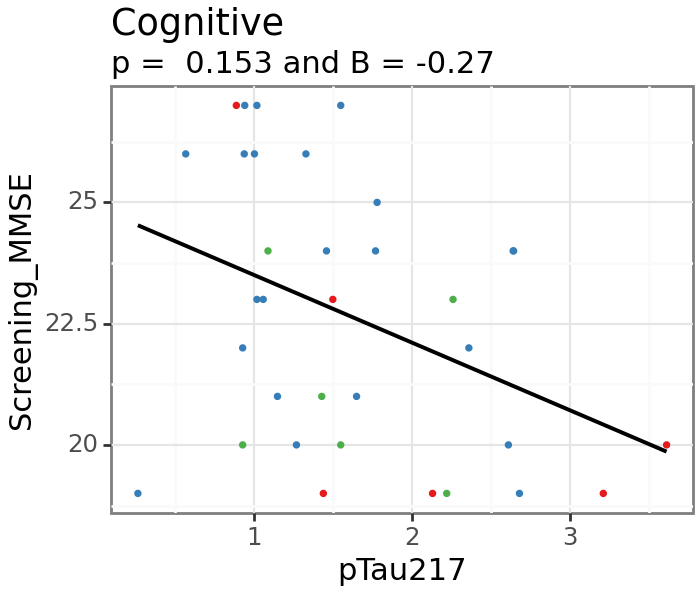

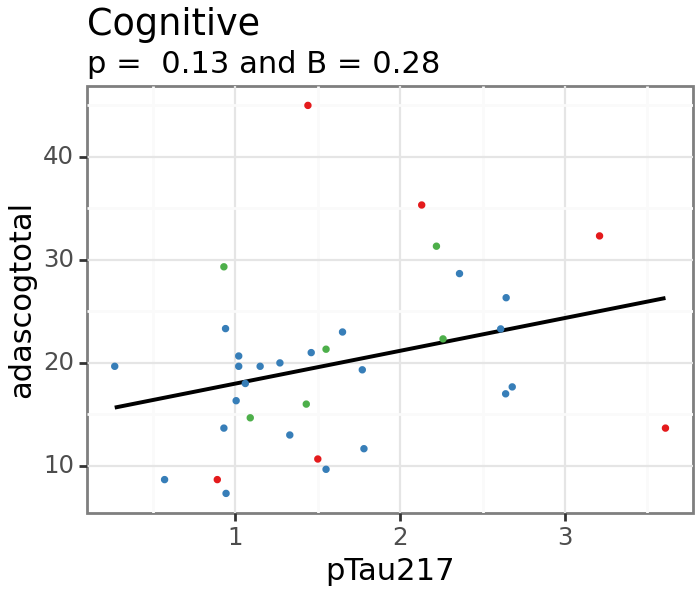

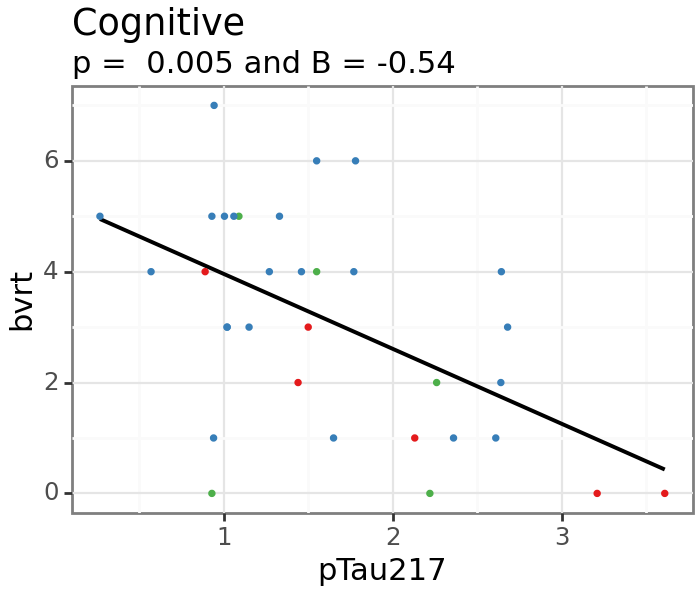

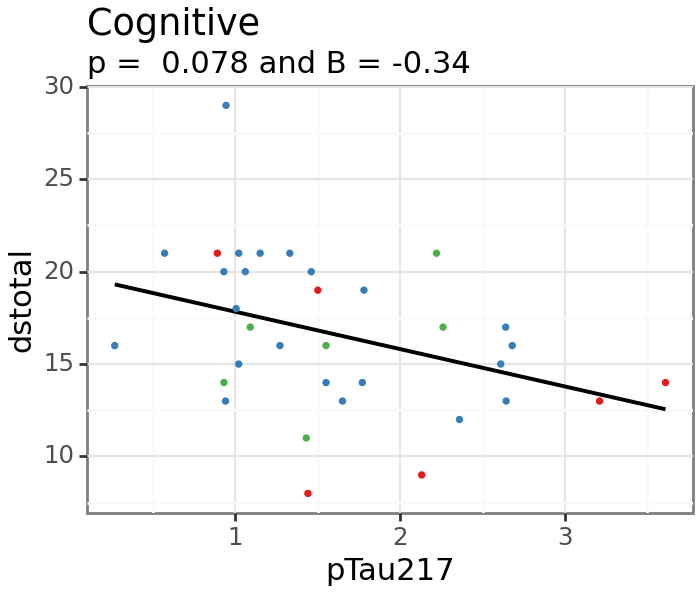

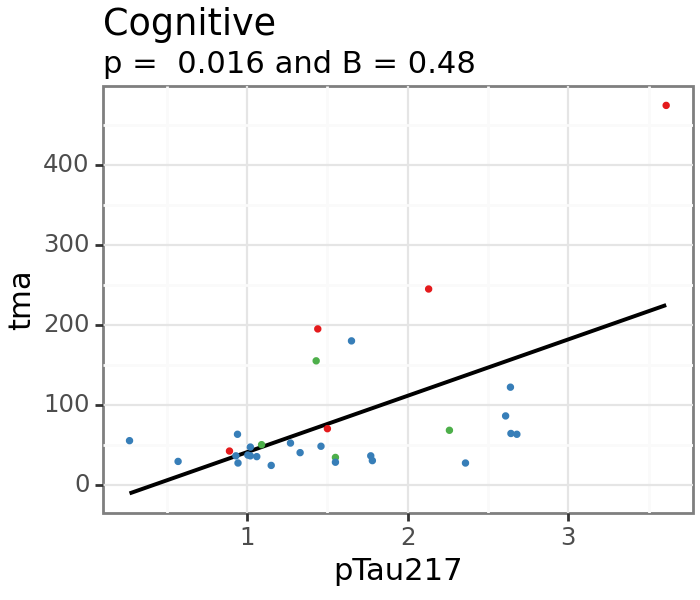

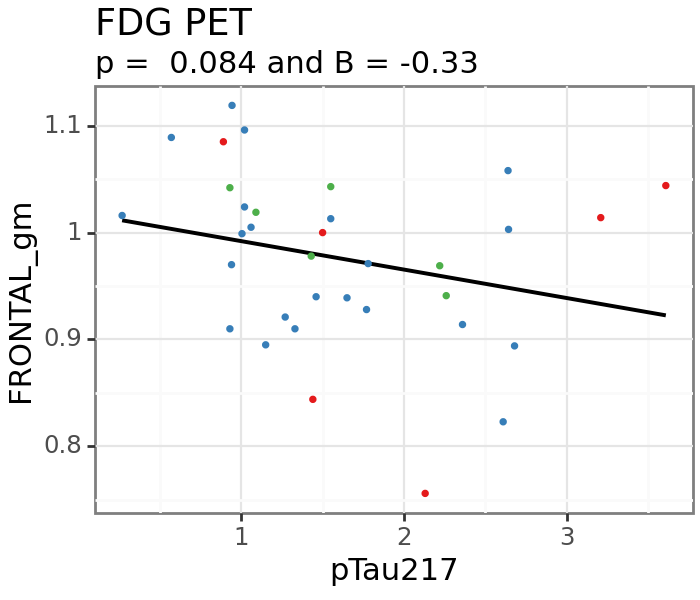

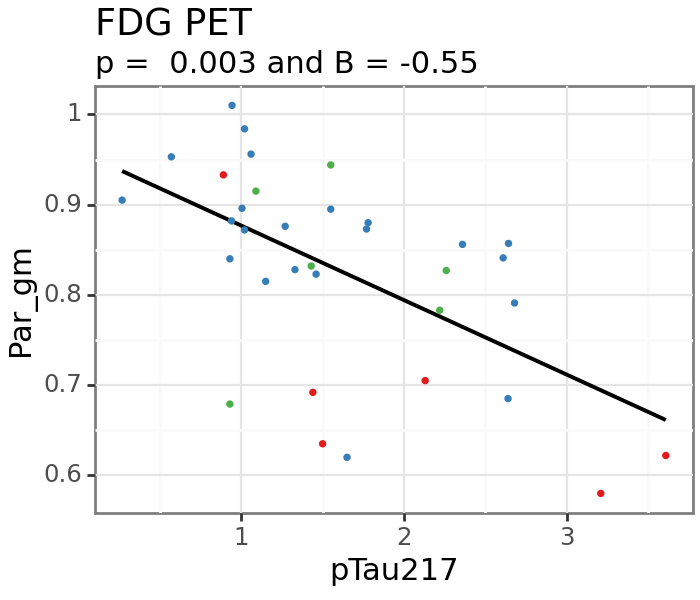

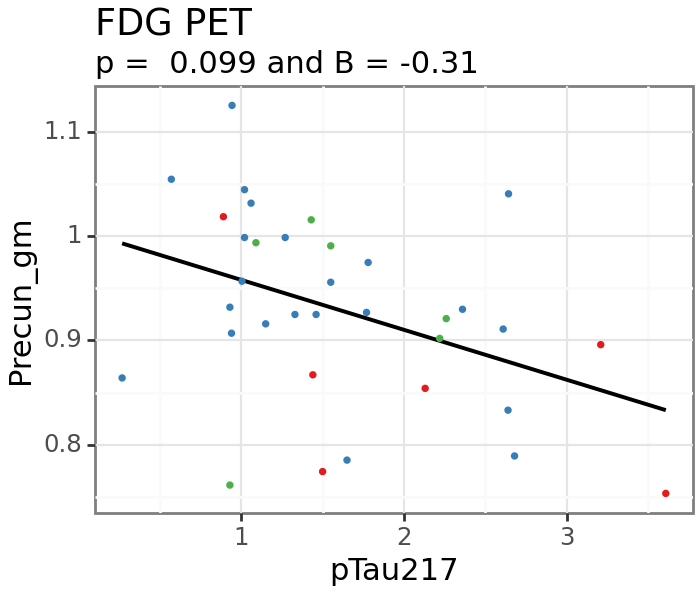

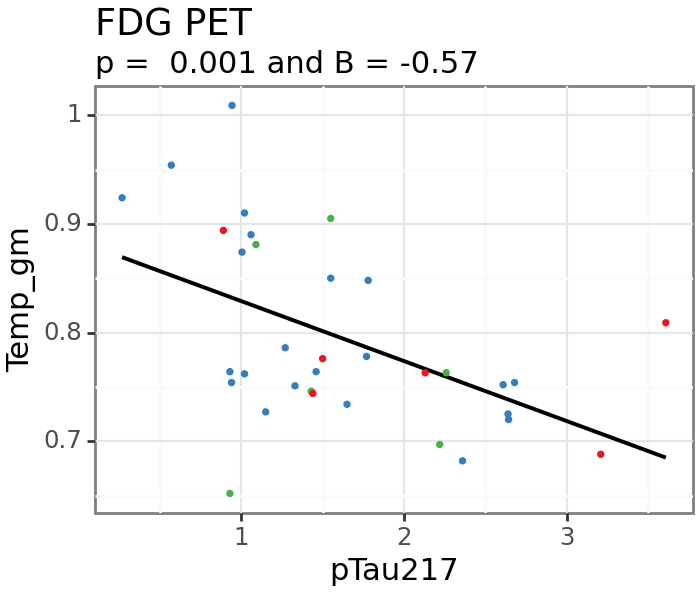

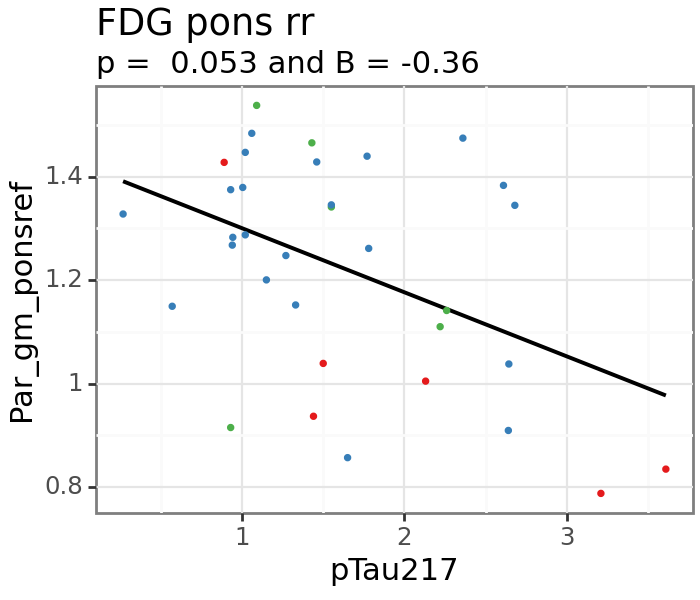

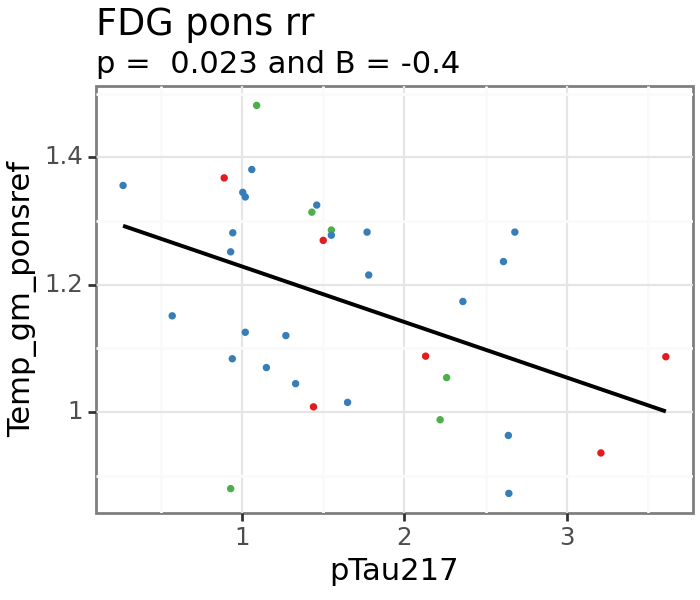

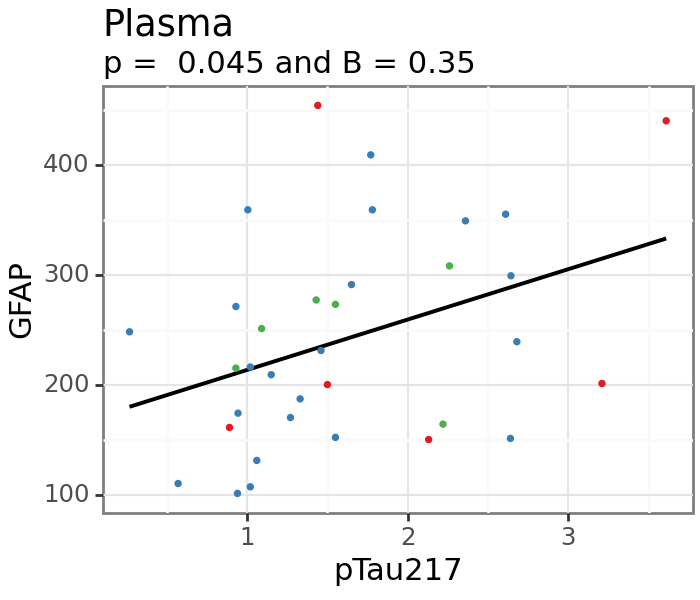

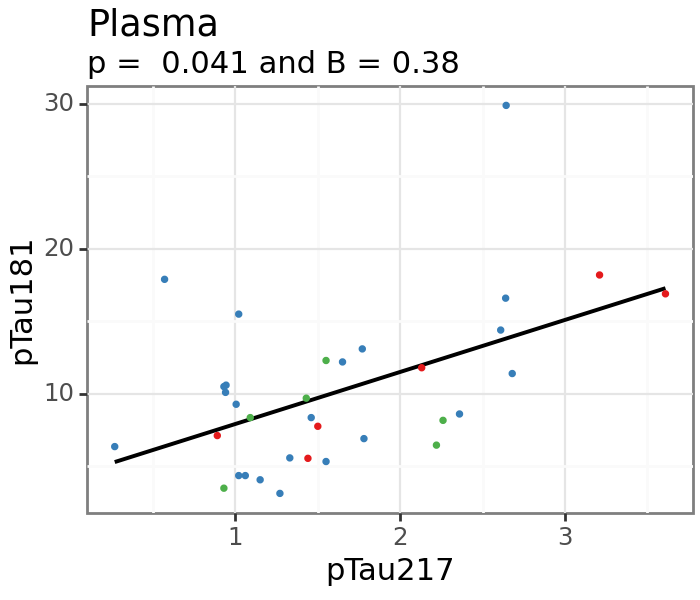

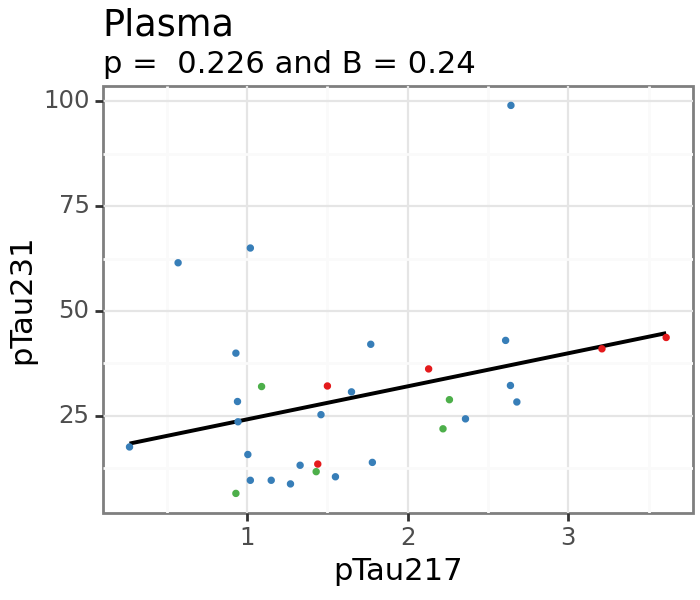

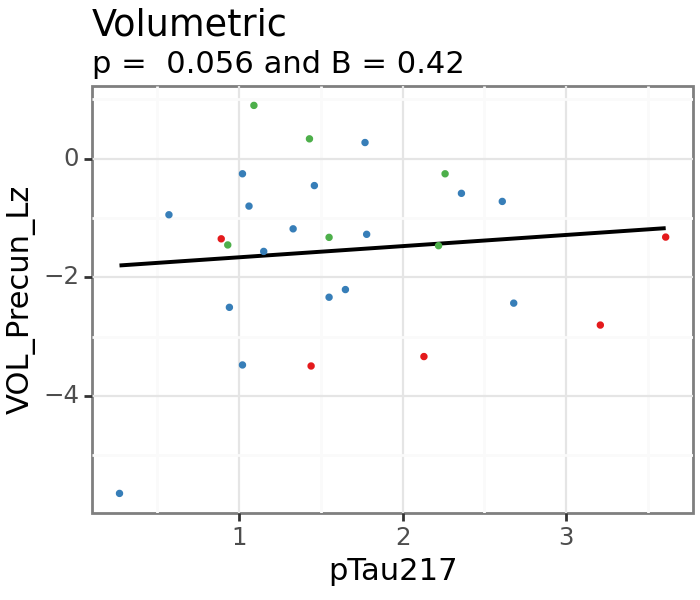

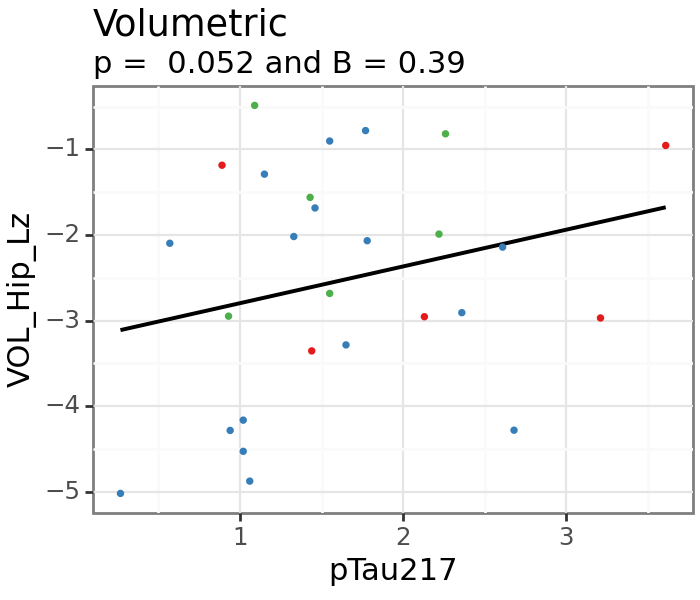

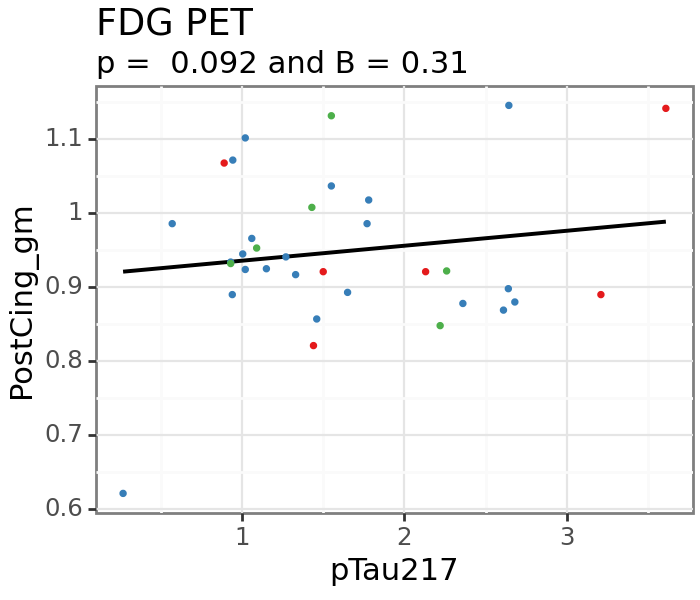

In [14]:
p9.options.figure_size = (3.5,3)    
var_list = ['Screening_MMSE', 'adascogtotal', 'bvrt', 'dstotal', 'tma', 'FRONTAL_gm', 'Par_gm', 'Precun_gm', 'Temp_gm', 'Par_gm_ponsref', 'Temp_gm_ponsref', 'GFAP', 
'pTau181', 'pTau231', 'VOL_Precun_Lz', 'VOL_Hip_Lz', 'PostCing_gm']

for var1 in var_list:
    p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), pvals_to_consider[0]].reset_index(drop=True)[0].round(3).astype('str')
    B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')

    var0 = var
    subset_data = baseline_data.dropna(subset = [var0, var1])
    subset_data2 = subset_data.copy()
    subset_data2 = subset_data2.groupby('age_decade2', observed=True).filter(lambda x: x['ID_ADM'].nunique()> 10)
    plot = (
            p9.ggplot(subset_data, p9.aes(x = var0, y = var1, color = 'age_decade2'))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(subset_data, size = 0.8, se = False, alpha = 1, color = 'black', method = 'lm')
            #+ p9.geom_smooth(subset_data2, size = 0.8, se = False, alpha = 1)
            + p9.geom_line(p9.aes(group = 'ID_ADM'), size = 0.2, linetype = '--')
            + p9.geom_point(size = 0.5)
            + p9.labs(subtitle = ('p =  ' + p_value + ' and B = ' + B_value), title = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), 'type'].reset_index(drop=True)[0])
            + p9.scale_color_brewer(type="qual", palette="Set1")
            + p9.theme(legend_position='none')
        )
    print(plot)

# pTau181

## main

In [15]:
var = 'pTau181'

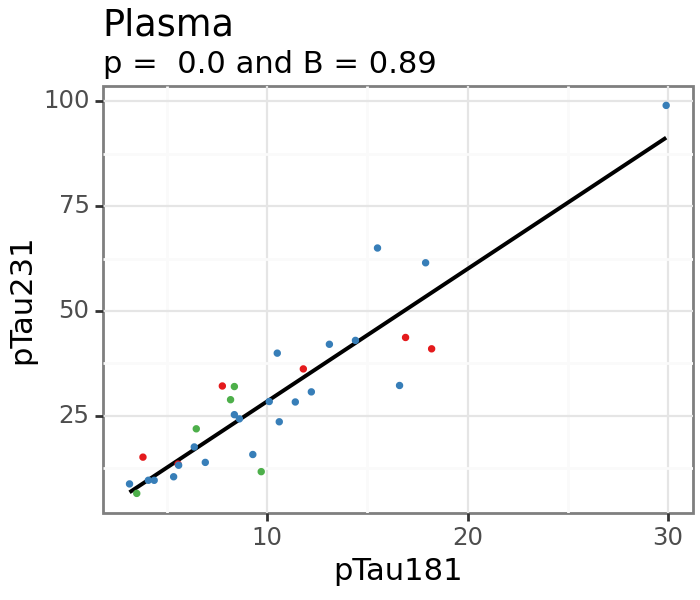

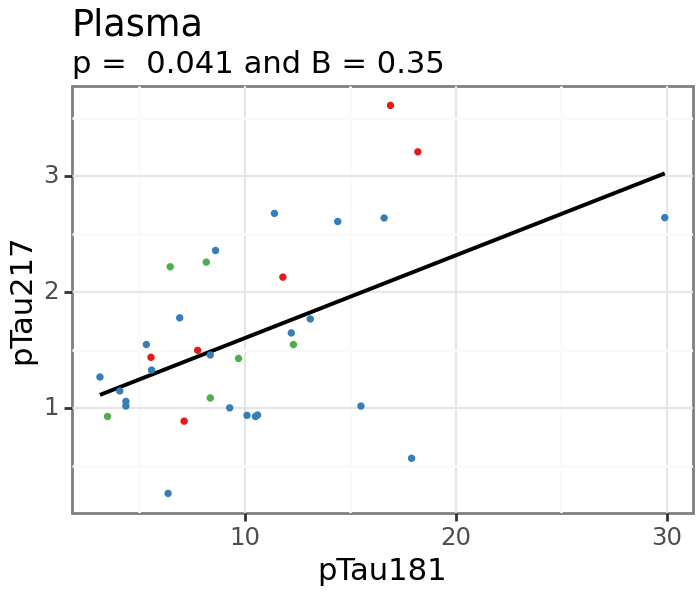

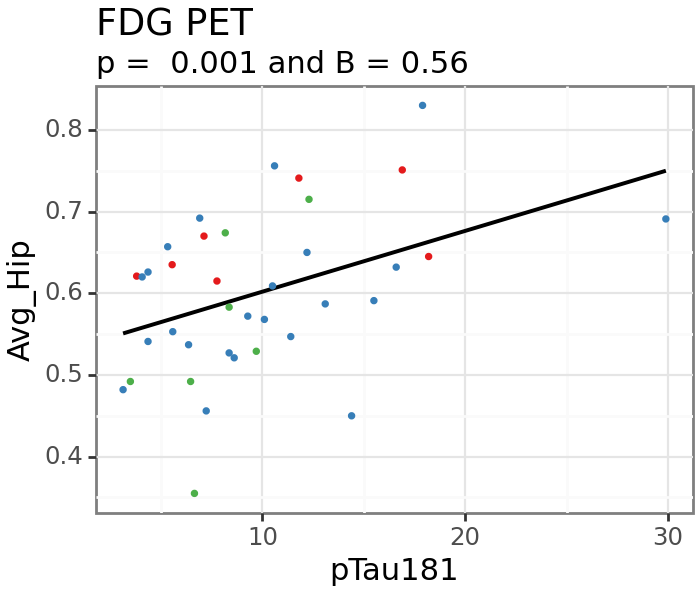

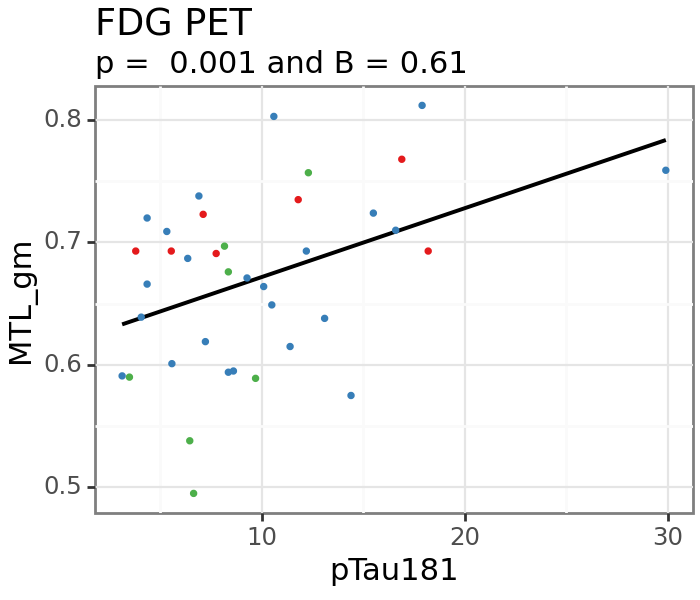

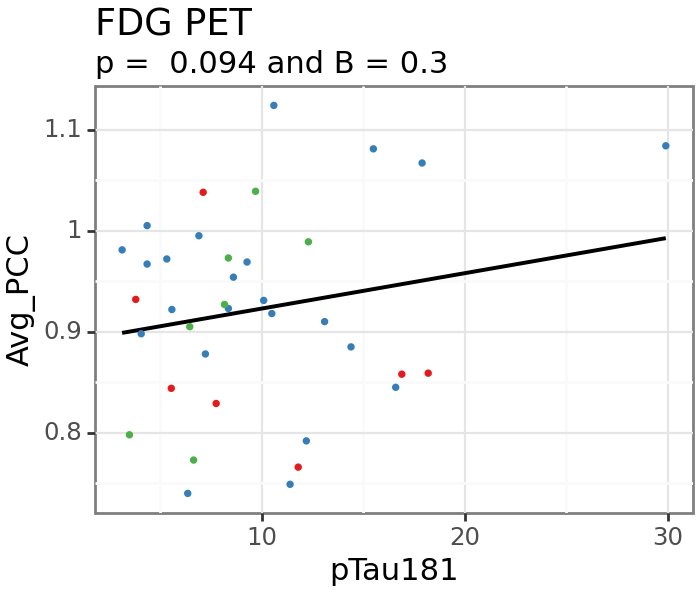

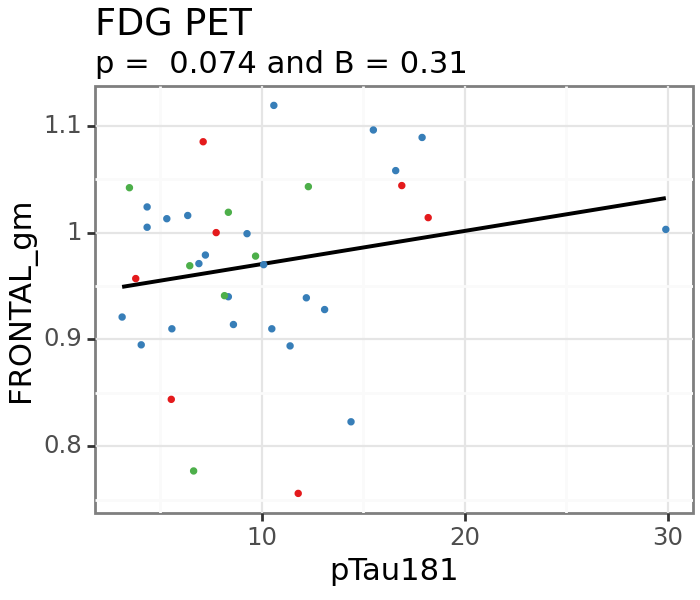

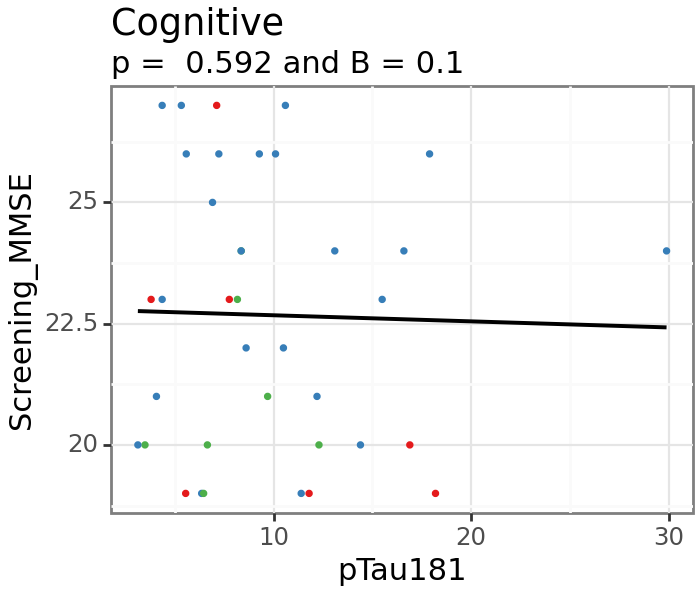

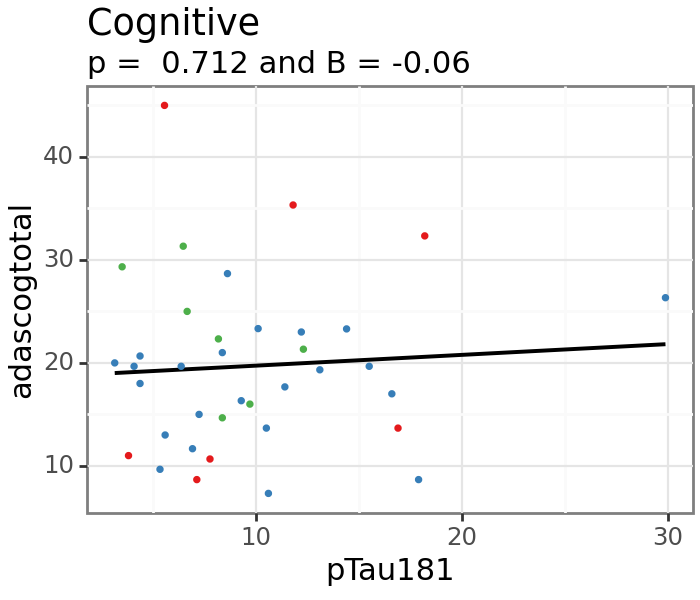

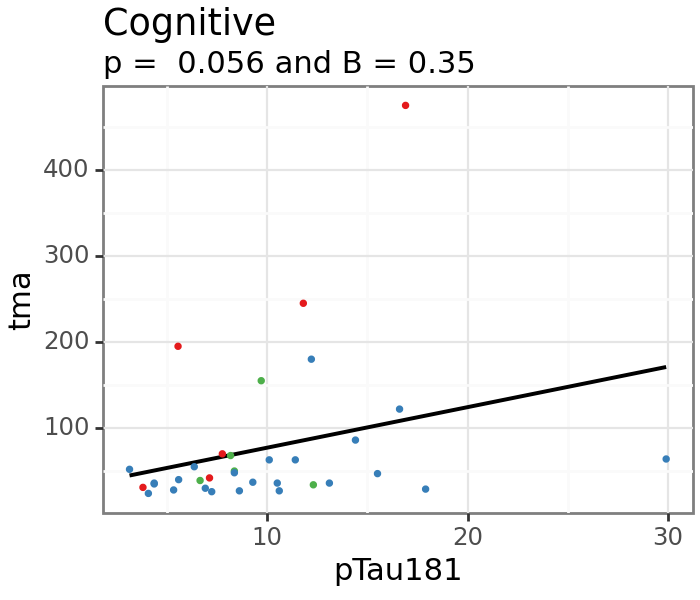

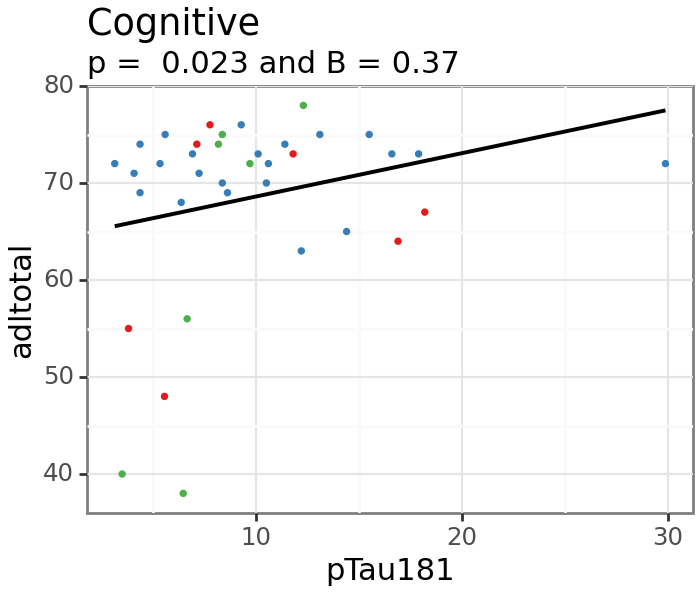

In [16]:
p9.options.figure_size = (3.5,3)    
var_list = ['pTau231', 'pTau217', 'Avg_Hip', 'MTL_gm', 'Avg_PCC', 'FRONTAL_gm', 'Screening_MMSE', 'adascogtotal', 'tma', 'adltotal']


for var1 in var_list:
    p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), pvals_to_consider[0]].reset_index(drop=True)[0].round(3).astype('str')
    B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')

    var0 = var
    subset_data = baseline_data.dropna(subset = [var0, var1])
    subset_data2 = subset_data.copy()
    subset_data2 = subset_data2.groupby('age_decade2', observed=True).filter(lambda x: x['ID_ADM'].nunique()> 10)
    plot = (
            p9.ggplot(subset_data, p9.aes(x = var0, y = var1, color = 'age_decade2'))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(subset_data, size = 0.8, se = False, alpha = 1, color = 'black', method = 'lm')
            #+ p9.geom_smooth(subset_data2, size = 0.8, se = False, alpha = 1)
            + p9.geom_line(p9.aes(group = 'ID_ADM'), size = 0.2, linetype = '--')
            + p9.geom_point(size = 0.5)
            + p9.labs(subtitle = ('p =  ' + p_value + ' and B = ' + B_value), title = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), 'type'].reset_index(drop=True)[0])
            + p9.scale_color_brewer(type="qual", palette="Set1")
            + p9.theme(legend_position='none')
        )
    print(plot)

## Repeat with separate age decade lines

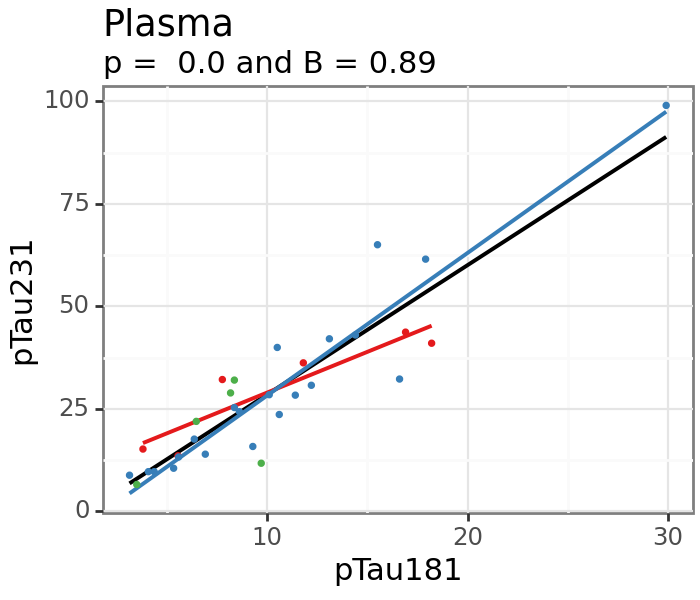

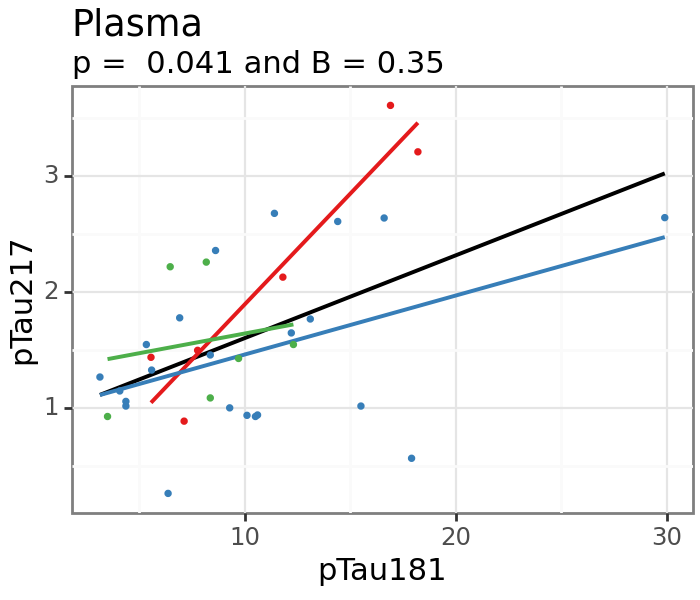

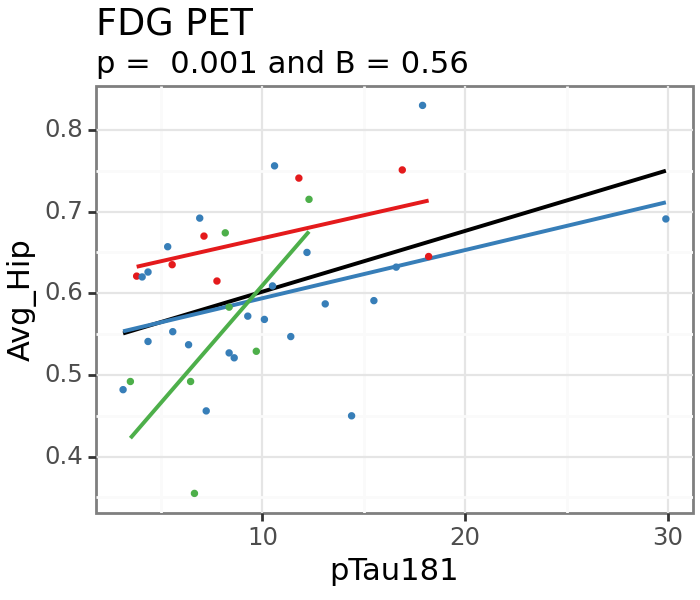

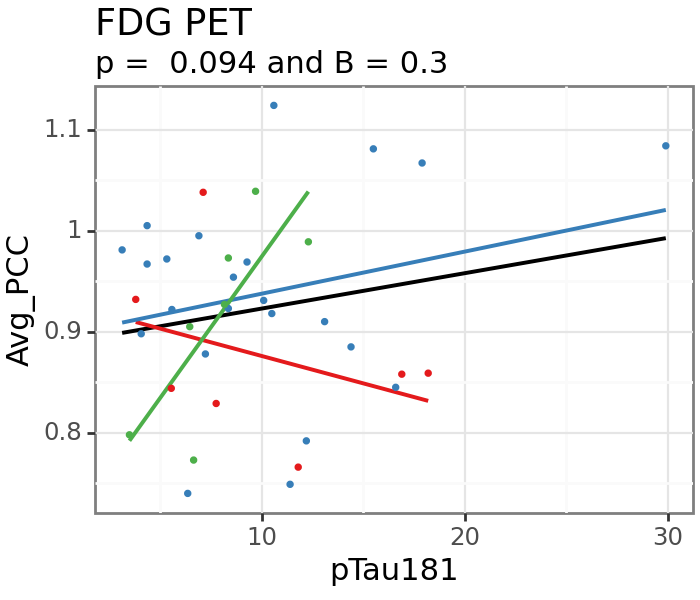

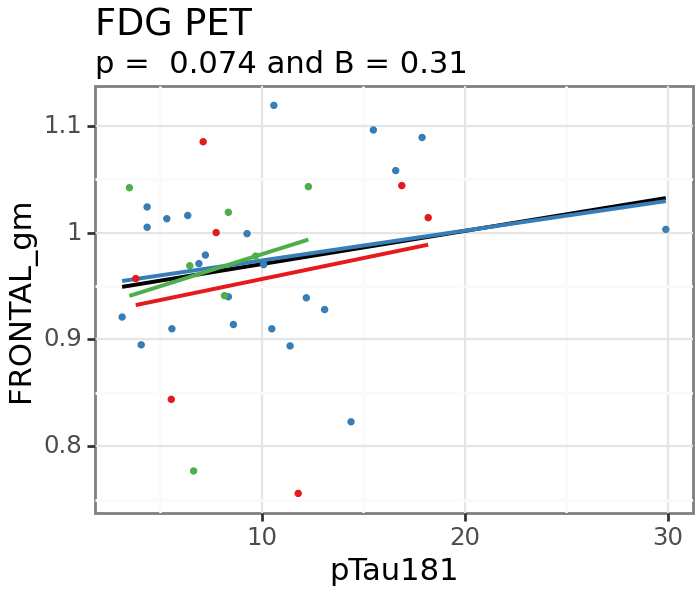

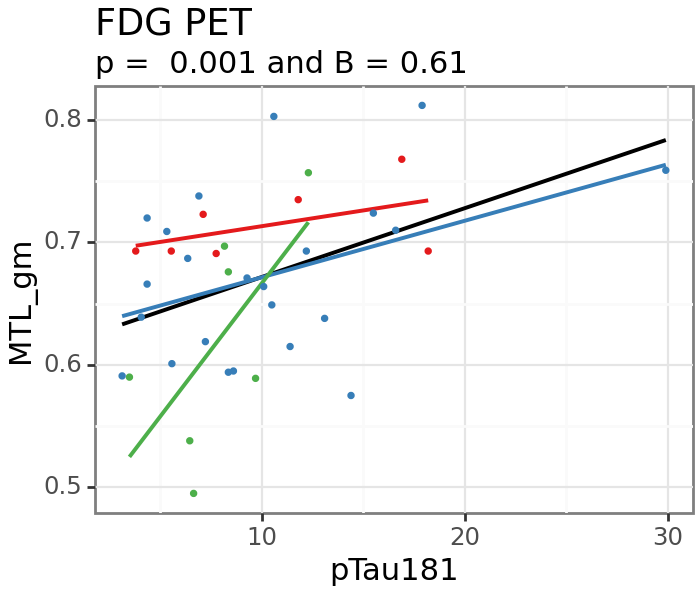

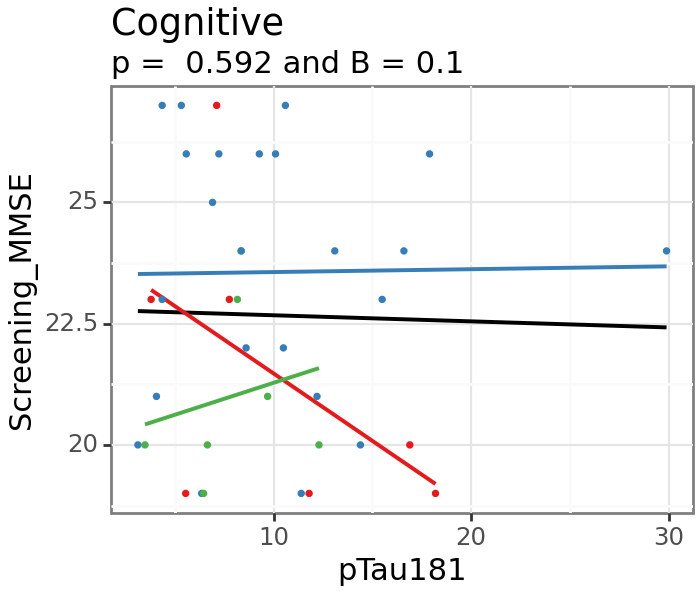

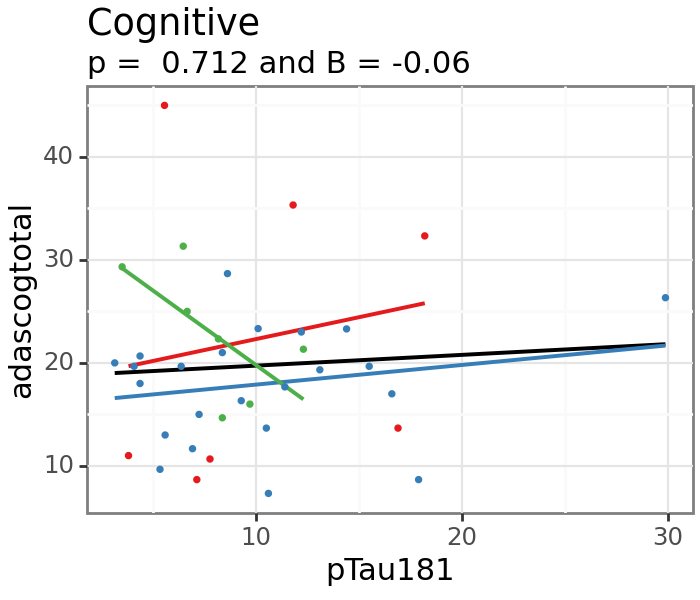

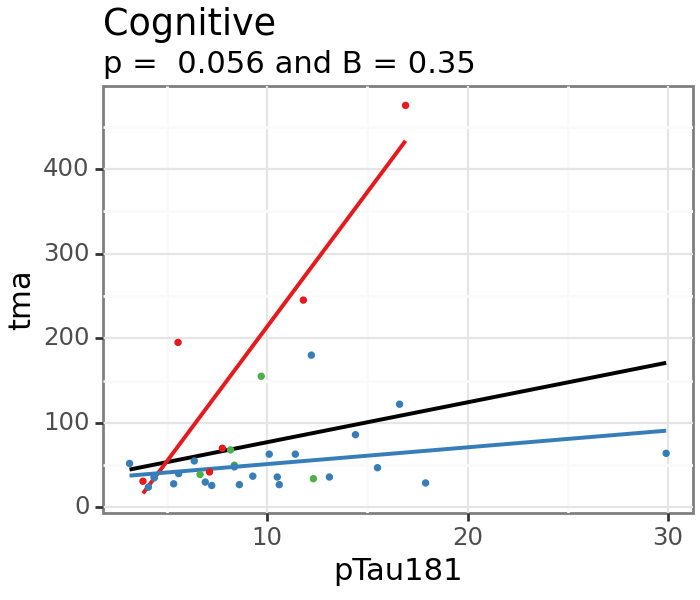

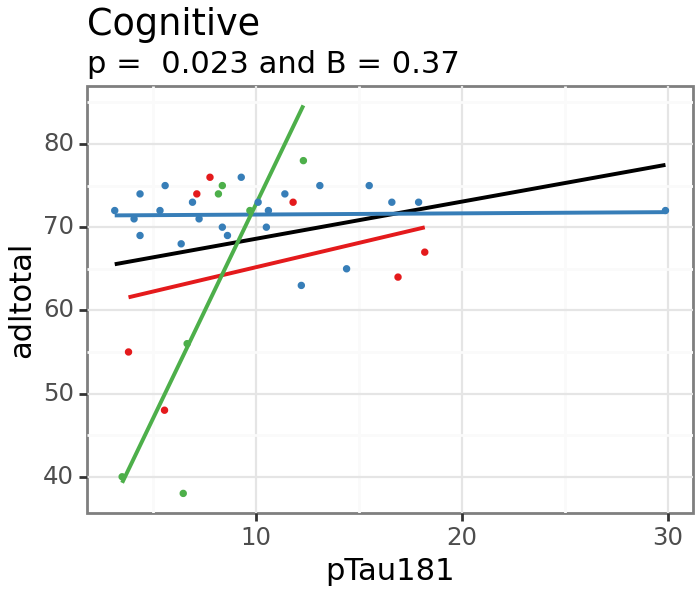

In [17]:
p9.options.figure_size = (3.5,3)    
var_list = ['pTau231', 'pTau217', 'Avg_Hip', 'Avg_PCC', 'FRONTAL_gm', 'MTL_gm', 'Screening_MMSE', 'adascogtotal', 'tma', 'adltotal']
 

for var1 in var_list:
    p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), pvals_to_consider[0]].reset_index(drop=True)[0].round(3).astype('str')
    B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')

    var0 = var
    subset_data = baseline_data.dropna(subset = [var0, var1])
    subset_data2 = subset_data.copy()
    subset_data2 = subset_data2.groupby('age_decade2', observed=True).filter(lambda x: x['ID_ADM'].nunique()> 5)
    plot = (
            p9.ggplot(subset_data, p9.aes(x = var0, y = var1, color = 'age_decade2'))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(subset_data, size = 0.8, se = False, alpha = 1, color = 'black', method = 'lm')
            + p9.geom_smooth(subset_data2, size = 0.8, se = False, alpha = 1, method = 'lm')
            + p9.geom_line(p9.aes(group = 'ID_ADM'), size = 0.2, linetype = '--')
            + p9.geom_point(size = 0.5)
            + p9.labs(subtitle = ('p =  ' + p_value + ' and B = ' + B_value), title = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), 'type'].reset_index(drop=True)[0])
            + p9.scale_color_brewer(type="qual", palette="Set1")
            + p9.theme(legend_position='none')

        )
    print(plot)

## CDR sum of boxes

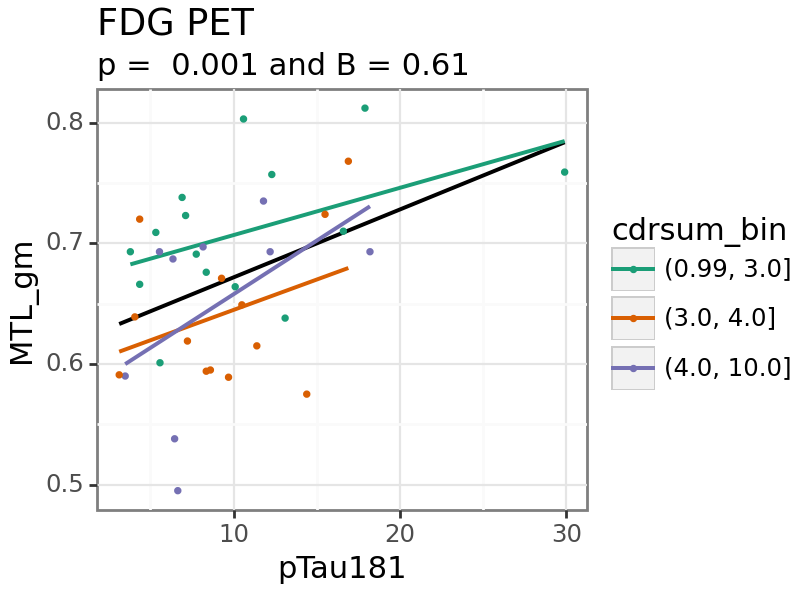

In [18]:
p9.options.figure_size = (4,3)  

for var1 in ['MTL_gm']:
    p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), pvals_to_consider[0]].reset_index(drop=True)[0].round(3).astype('str')
    B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')

    var0 = var
    subset_data = baseline_data.dropna(subset = [var0, var1])
    subset_data2 = subset_data.copy()
    subset_data2 = subset_data2.groupby('cdrsum_bin', observed=True).filter(lambda x: x['ID_ADM'].nunique()> 6)
    plot = (
            p9.ggplot(subset_data, p9.aes(x = var0, y = var1, color = 'cdrsum_bin'))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(subset_data, size = 0.8, se = False, alpha = 1, color = 'black', method = 'lm')
            + p9.geom_smooth(subset_data2, size = 0.8, se = False, alpha = 1, method = 'lm')
            + p9.geom_line(p9.aes(group = 'ID_ADM'), size = 0.2, linetype = '--')
            + p9.geom_point(size = 0.5)
            + p9.labs(subtitle = ('p =  ' + p_value + ' and B = ' + B_value), title = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), 'type'].reset_index(drop=True)[0])
            + p9.scale_color_brewer(type="qual", palette="Dark2")
        )
    print(plot)

## MMSE

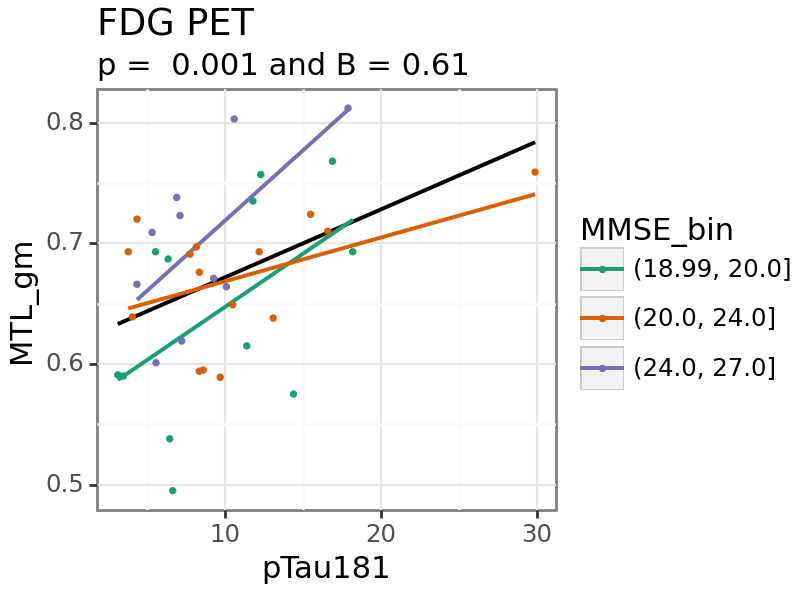

In [19]:
p9.options.figure_size = (4,3)  

for var1 in ['MTL_gm']:
    p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), pvals_to_consider[0]].reset_index(drop=True)[0].round(3).astype('str')
    B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')

    var0 = var
    subset_data = baseline_data.dropna(subset = [var0, var1])
    subset_data2 = subset_data.copy()
    subset_data2 = subset_data2.groupby('MMSE_bin', observed=True).filter(lambda x: x['ID_ADM'].nunique()> 6)
    plot = (
            p9.ggplot(subset_data, p9.aes(x = var0, y = var1, color = 'MMSE_bin'))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(subset_data, size = 0.8, se = False, alpha = 1, color = 'black', method = 'lm')
            + p9.geom_smooth(subset_data2, size = 0.8, se = False, alpha = 1, method = 'lm')
            + p9.geom_line(p9.aes(group = 'ID_ADM'), size = 0.2, linetype = '--')
            + p9.geom_point(size = 0.5)
            + p9.labs(subtitle = ('p =  ' + p_value + ' and B = ' + B_value), title = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), 'type'].reset_index(drop=True)[0])
            + p9.scale_color_brewer(type="qual", palette="Dark2")
        )
    print(plot)

## Ab42/40 

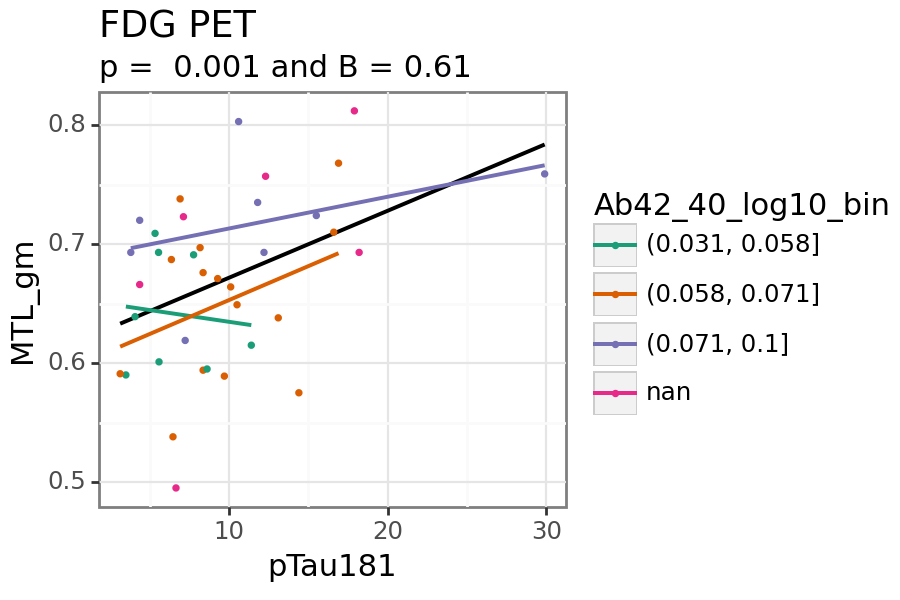

In [20]:
p9.options.figure_size = (4.5,3)  

for var1 in ['MTL_gm']:
    p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), pvals_to_consider[0]].reset_index(drop=True)[0].round(3).astype('str')
    B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')

    var0 = var
    subset_data = baseline_data.dropna(subset = [var0, var1])
    subset_data2 = subset_data.copy()
    subset_data2 = subset_data2.groupby('Ab42_40_log10_bin', observed=True).filter(lambda x: x['ID_ADM'].nunique()> 6)
    plot = (
            p9.ggplot(subset_data, p9.aes(x = var0, y = var1, color = 'Ab42_40_log10_bin'))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(subset_data, size = 0.8, se = False, alpha = 1, color = 'black', method = 'lm')
            + p9.geom_smooth(subset_data2, size = 0.8, se = False, alpha = 1, method = 'lm')
            + p9.geom_line(p9.aes(group = 'ID_ADM'), size = 0.2, linetype = '--')
            + p9.geom_point(size = 0.5)
            + p9.labs(subtitle = ('p =  ' + p_value + ' and B = ' + B_value), title = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), 'type'].reset_index(drop=True)[0])
            + p9.scale_color_brewer(type="qual", palette="Dark2")
        )
    print(plot)

## pTau217

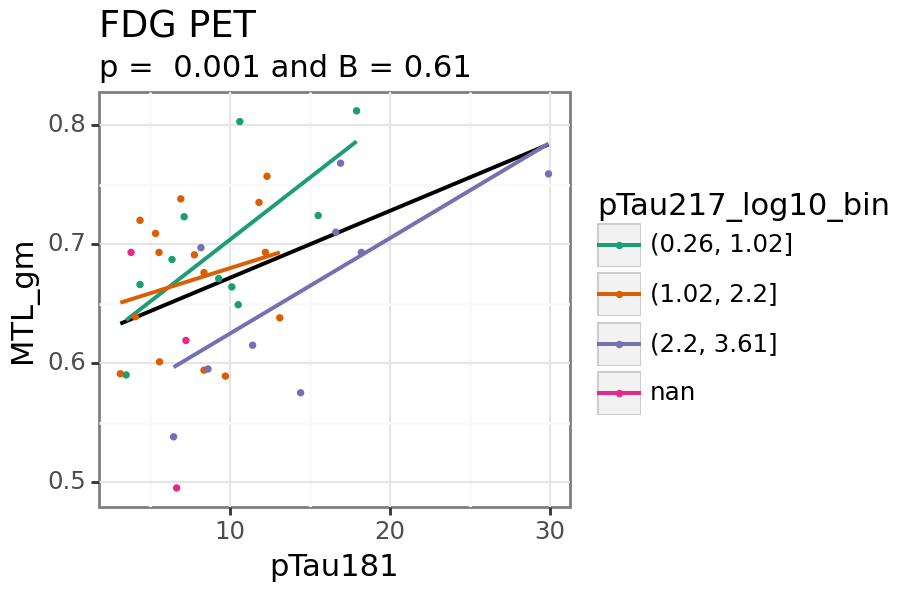

In [21]:
p9.options.figure_size = (4.5,3)  

for var1 in ['MTL_gm']:
    p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), pvals_to_consider[0]].reset_index(drop=True)[0].round(3).astype('str')
    B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')

    var0 = var
    subset_data = baseline_data.dropna(subset = [var0, var1])
    subset_data2 = subset_data.copy()
    subset_data2 = subset_data2.groupby('pTau217_log10_bin', observed=True).filter(lambda x: x['ID_ADM'].nunique()> 6)
    plot = (
            p9.ggplot(subset_data, p9.aes(x = var0, y = var1, color = 'pTau217_log10_bin'))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(subset_data, size = 0.8, se = False, alpha = 1, color = 'black', method = 'lm')
            + p9.geom_smooth(subset_data2, size = 0.8, se = False, alpha = 1, method = 'lm')
            + p9.geom_line(p9.aes(group = 'ID_ADM'), size = 0.2, linetype = '--')
            + p9.geom_point(size = 0.5)
            + p9.labs(subtitle = ('p =  ' + p_value + ' and B = ' + B_value), title = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), 'type'].reset_index(drop=True)[0])
            + p9.scale_color_brewer(type="qual", palette="Dark2")
        )
    print(plot)

## GFAP

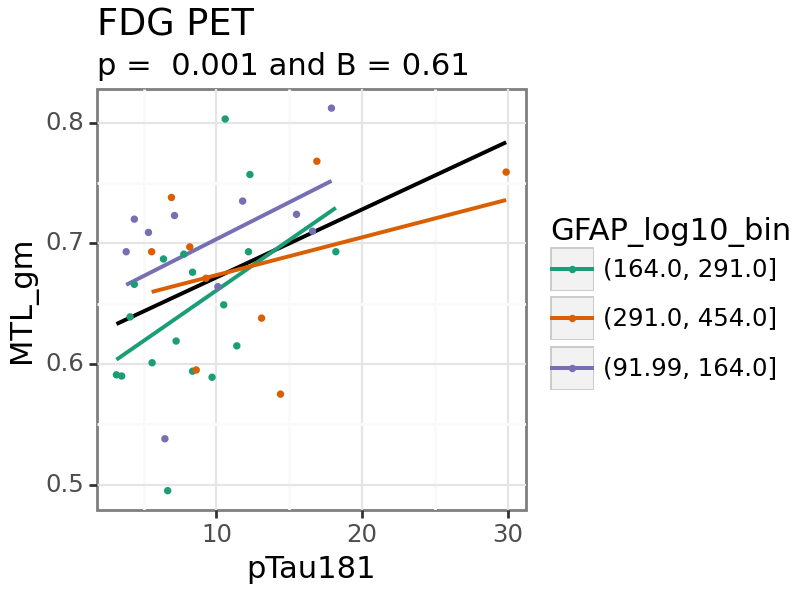

In [22]:
var = 'pTau181'
p9.options.figure_size = (4,3)  

for var1 in ['MTL_gm']:
    p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), pvals_to_consider[0]].reset_index(drop=True)[0].round(3).astype('str')
    B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')

    var0 = var
    subset_data = baseline_data.dropna(subset = [var0, var1])
    subset_data2 = subset_data.copy()
    subset_data2 = subset_data2.groupby('GFAP_log10_bin', observed=True).filter(lambda x: x['ID_ADM'].nunique()> 6)
    plot = (
            p9.ggplot(subset_data, p9.aes(x = var0, y = var1, color = 'GFAP_log10_bin'))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(subset_data, size = 0.8, se = False, alpha = 1, color = 'black', method = 'lm')
            + p9.geom_smooth(subset_data2, size = 0.8, se = False, alpha = 1, method = 'lm')
            + p9.geom_line(p9.aes(group = 'ID_ADM'), size = 0.2, linetype = '--')
            + p9.geom_point(size = 0.5)
            + p9.labs(subtitle = ('p =  ' + p_value + ' and B = ' + B_value), title = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), 'type'].reset_index(drop=True)[0])
            + p9.scale_color_brewer(type="qual", palette="Dark2")
        )
    print(plot)

## NFL

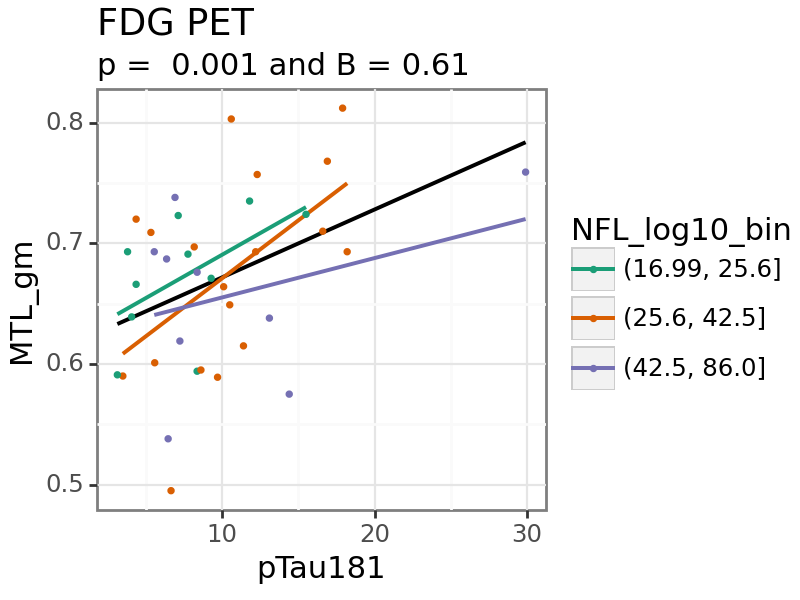

In [23]:
var = 'pTau181'
p9.options.figure_size = (4,3)  

for var1 in ['MTL_gm']:
    p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), pvals_to_consider[0]].reset_index(drop=True)[0].round(3).astype('str')
    B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')

    var0 = var
    subset_data = baseline_data.dropna(subset = [var0, var1])
    subset_data2 = subset_data.copy()
    subset_data2 = subset_data2.groupby('NFL_log10_bin', observed=True).filter(lambda x: x['ID_ADM'].nunique()> 6)
    plot = (
            p9.ggplot(subset_data, p9.aes(x = var0, y = var1, color = 'NFL_log10_bin'))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(subset_data, size = 0.8, se = False, alpha = 1, color = 'black', method = 'lm')
            + p9.geom_smooth(subset_data2, size = 0.8, se = False, alpha = 1, method = 'lm')
            + p9.geom_line(p9.aes(group = 'ID_ADM'), size = 0.2, linetype = '--')
            + p9.geom_point(size = 0.5)
            + p9.labs(subtitle = ('p =  ' + p_value + ' and B = ' + B_value), title = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), 'type'].reset_index(drop=True)[0])
            + p9.scale_color_brewer(type="qual", palette="Dark2")
        )
    print(plot)

## Hip Vol

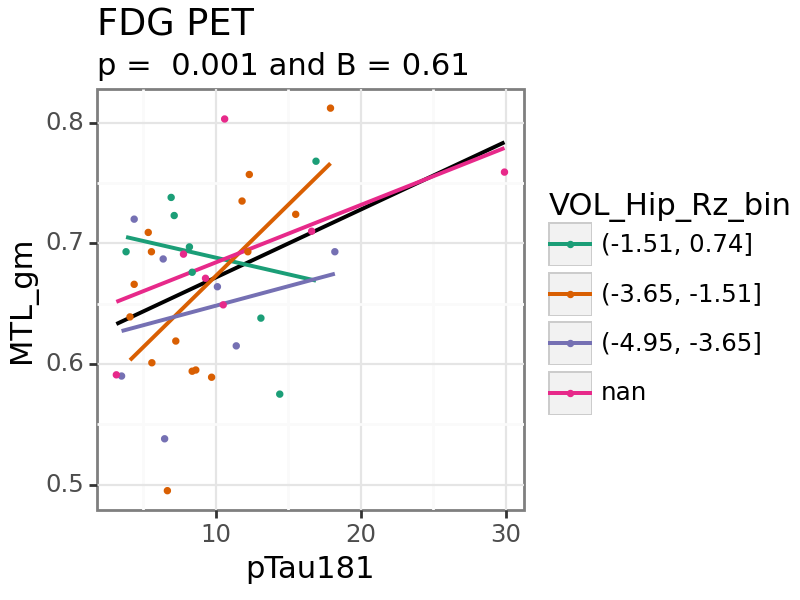

In [24]:
var = 'pTau181'
p9.options.figure_size = (4,3)  

for var1 in ['MTL_gm']:
    p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), pvals_to_consider[0]].reset_index(drop=True)[0].round(3).astype('str')
    B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')

    var0 = var
    subset_data = baseline_data.dropna(subset = [var0, var1])
    subset_data2 = subset_data.copy()
    subset_data2 = subset_data2.groupby('VOL_Hip_Rz_bin', observed=True).filter(lambda x: x['ID_ADM'].nunique()> 6)
    plot = (
            p9.ggplot(subset_data, p9.aes(x = var0, y = var1, color = 'VOL_Hip_Rz_bin'))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(subset_data, size = 0.8, se = False, alpha = 1, color = 'black', method = 'lm')
            + p9.geom_smooth(subset_data2, size = 0.8, se = False, alpha = 1, method = 'lm')
            + p9.geom_line(p9.aes(group = 'ID_ADM'), size = 0.2, linetype = '--')
            + p9.geom_point(size = 0.5)
            + p9.labs(subtitle = ('p =  ' + p_value + ' and B = ' + B_value), title = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), 'type'].reset_index(drop=True)[0])
            + p9.scale_color_brewer(type="qual", palette="Dark2")
        )
    print(plot)

# pTau231

In [25]:
var = 'pTau231'

## Main

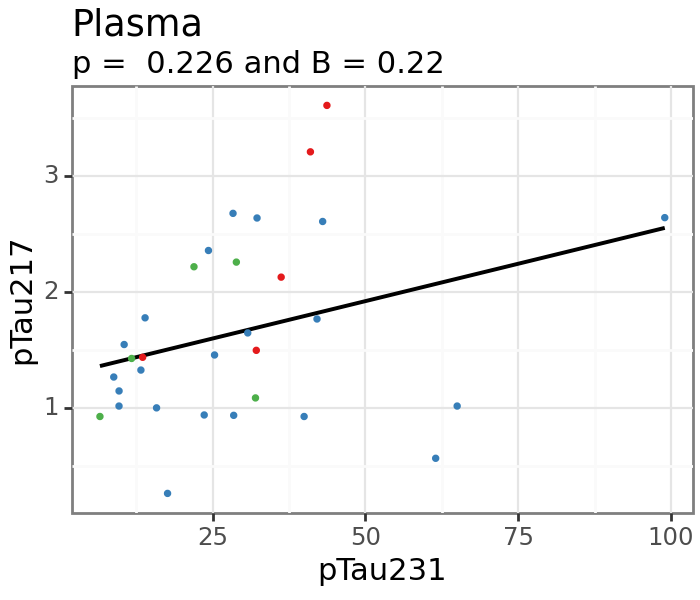

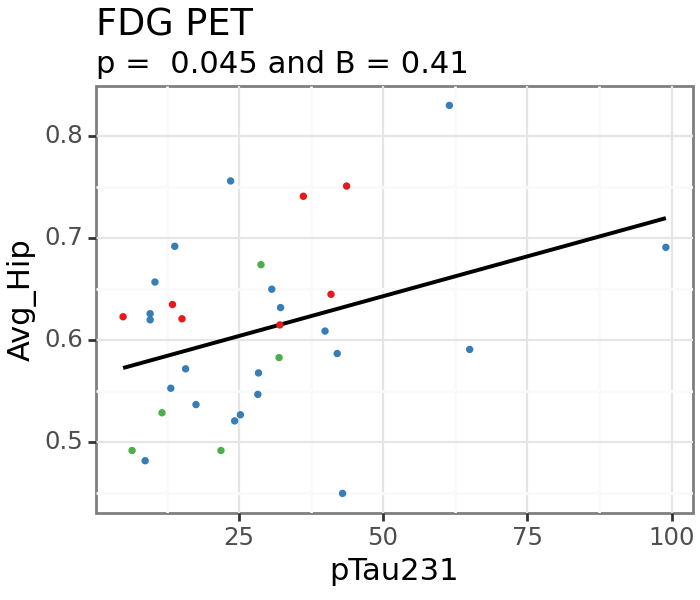

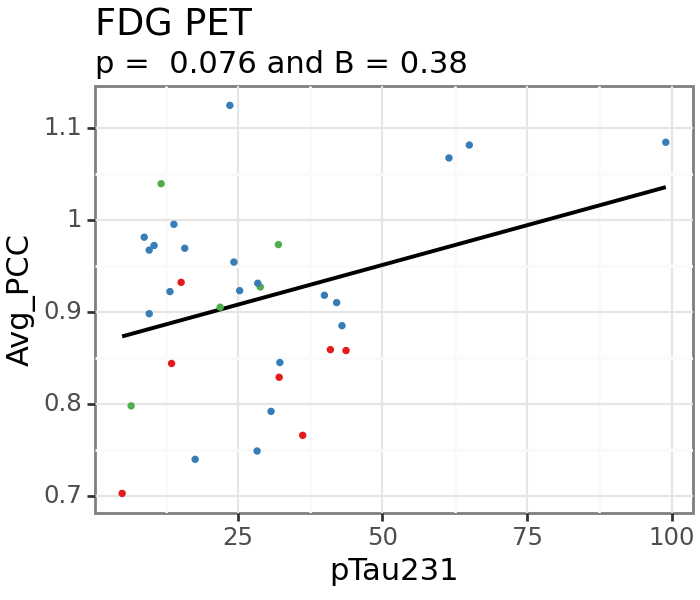

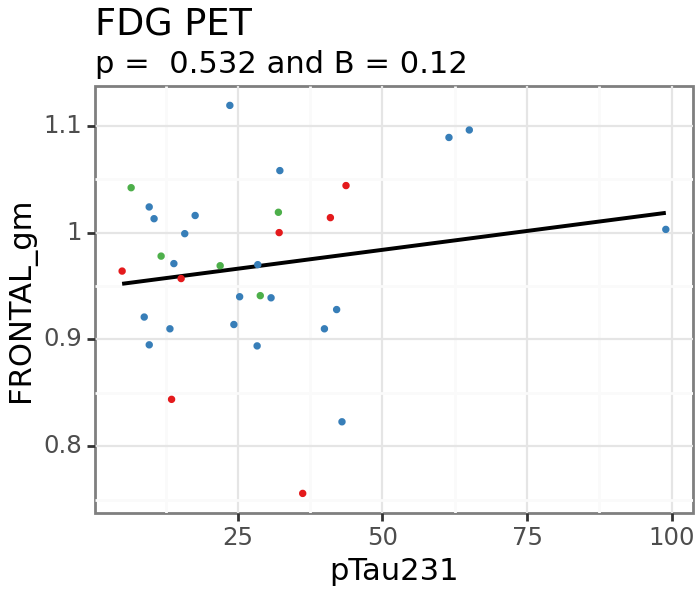

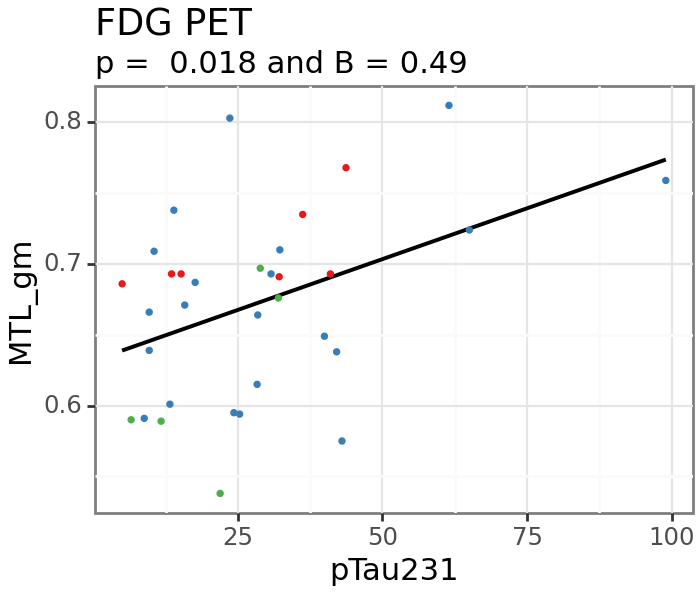

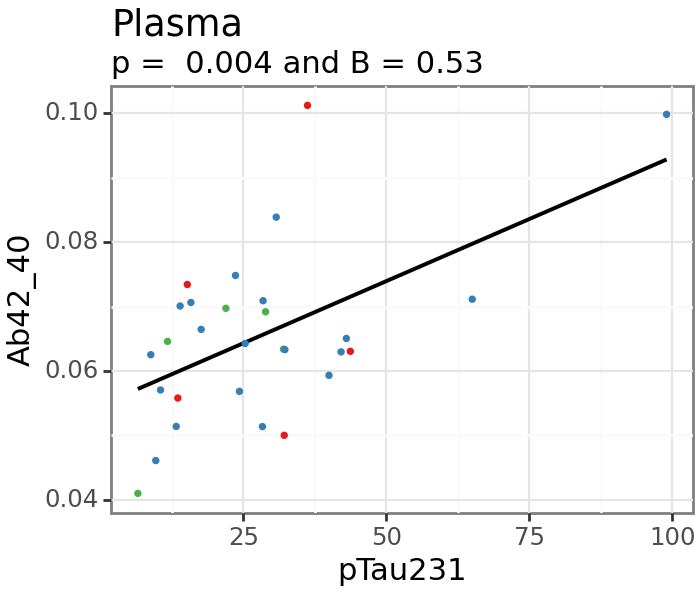

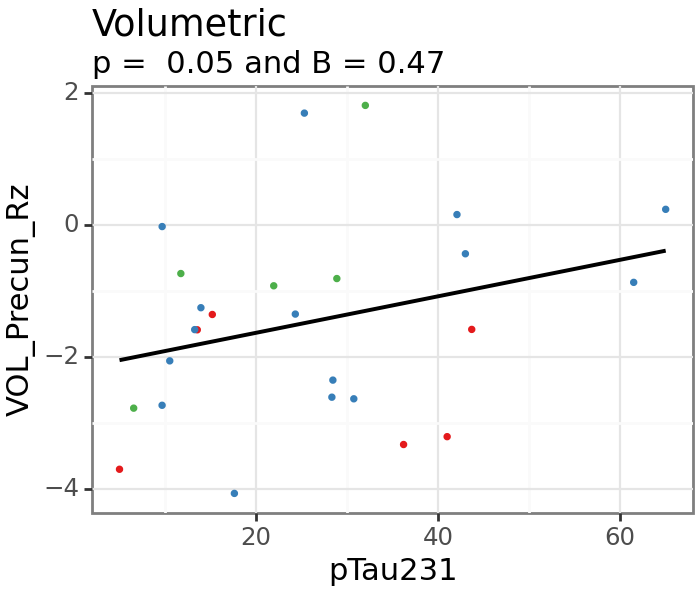

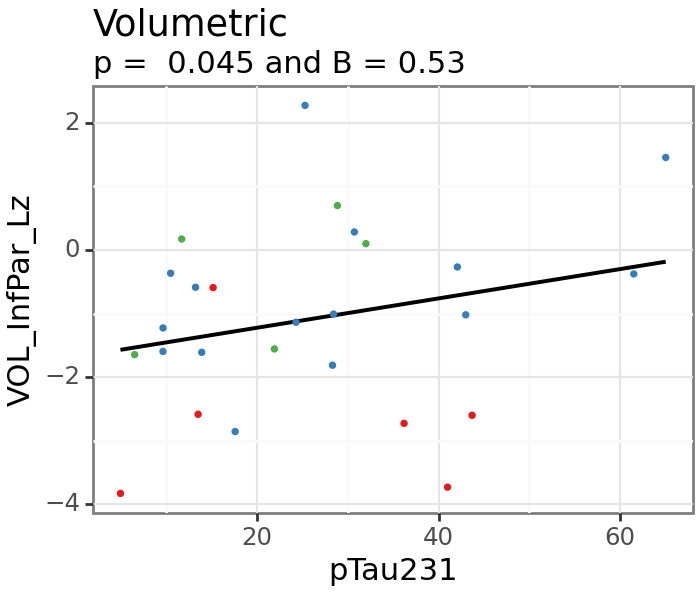

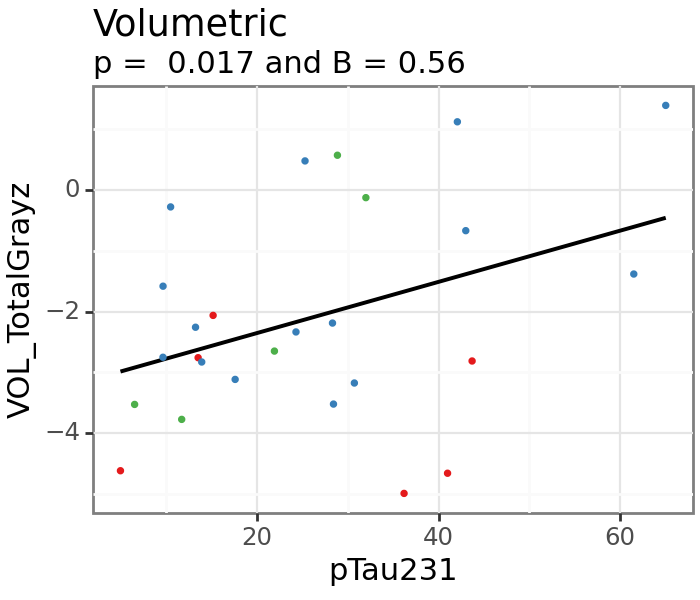

In [26]:
p9.options.figure_size = (3.5,3)    
var_list = ['pTau217', 'Avg_Hip', 'Avg_PCC', 'FRONTAL_gm', 'MTL_gm', 'Ab42_40', 'VOL_Precun_Rz', 'VOL_InfPar_Lz', 'VOL_TotalGrayz']

for var1 in var_list:
    p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), pvals_to_consider[0]].reset_index(drop=True)[0].round(3).astype('str')
    B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')

    var0 = var
    subset_data = baseline_data.dropna(subset = [var0, var1])
    subset_data2 = subset_data.copy()
    subset_data2 = subset_data2.groupby('age_decade2', observed=True).filter(lambda x: x['ID_ADM'].nunique()> 10)
    plot = (
            p9.ggplot(subset_data, p9.aes(x = var0, y = var1, color = 'age_decade2'))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(subset_data, size = 0.8, se = False, alpha = 1, color = 'black', method = 'lm')
            #+ p9.geom_smooth(subset_data2, size = 0.8, se = False, alpha = 1)
            + p9.geom_line(p9.aes(group = 'ID_ADM'), size = 0.2, linetype = '--')
            + p9.geom_point(size = 0.5)
            + p9.labs(subtitle = ('p =  ' + p_value + ' and B = ' + B_value), title = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), 'type'].reset_index(drop=True)[0])
            + p9.scale_color_brewer(type="qual", palette="Set1")
            + p9.theme(legend_position='none')
        )
    print(plot)

## Repeat with separate age decade lines

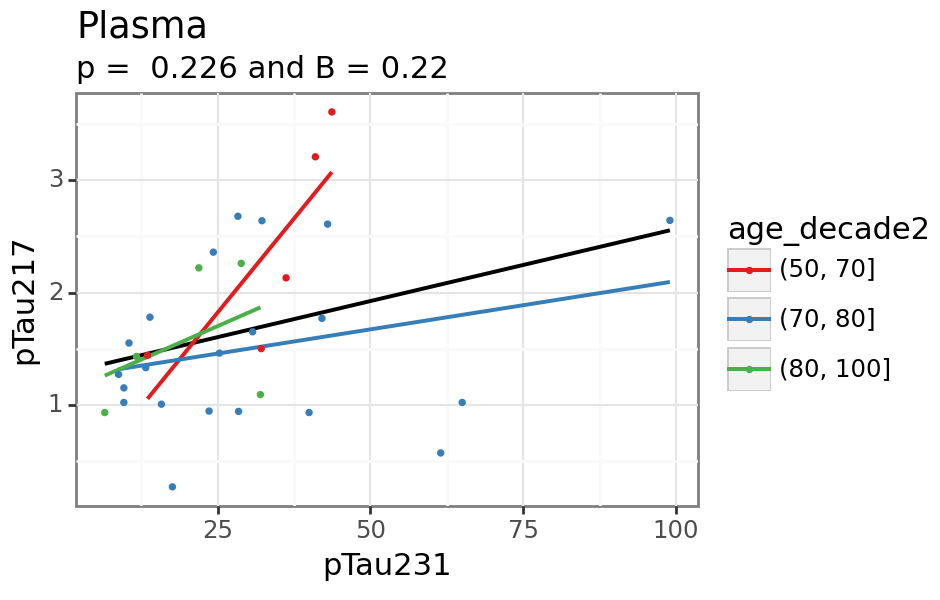

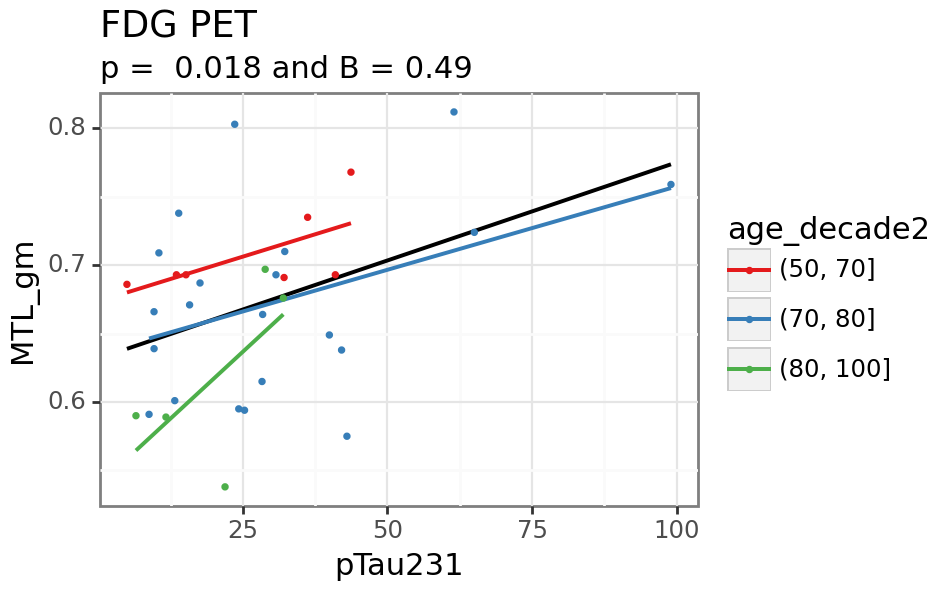

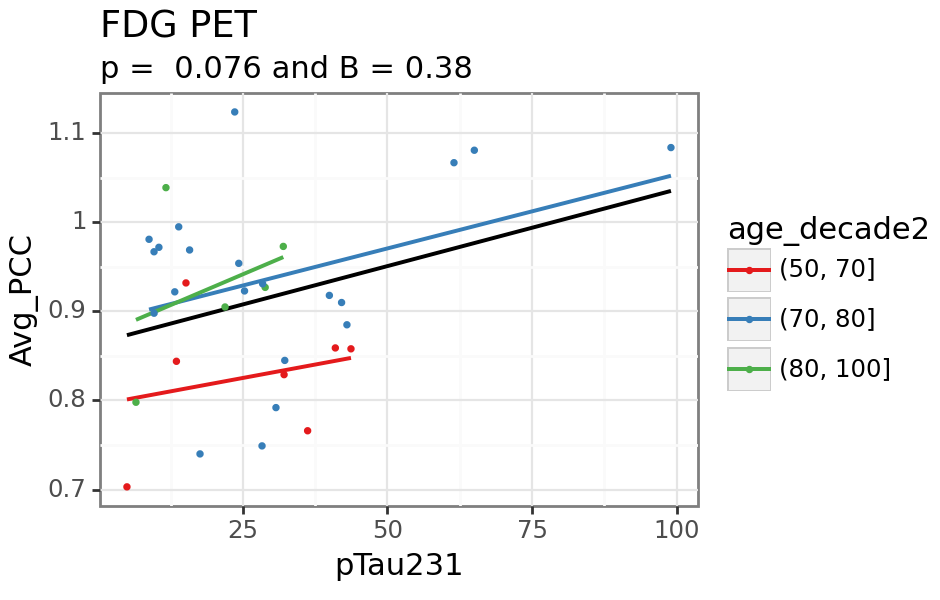

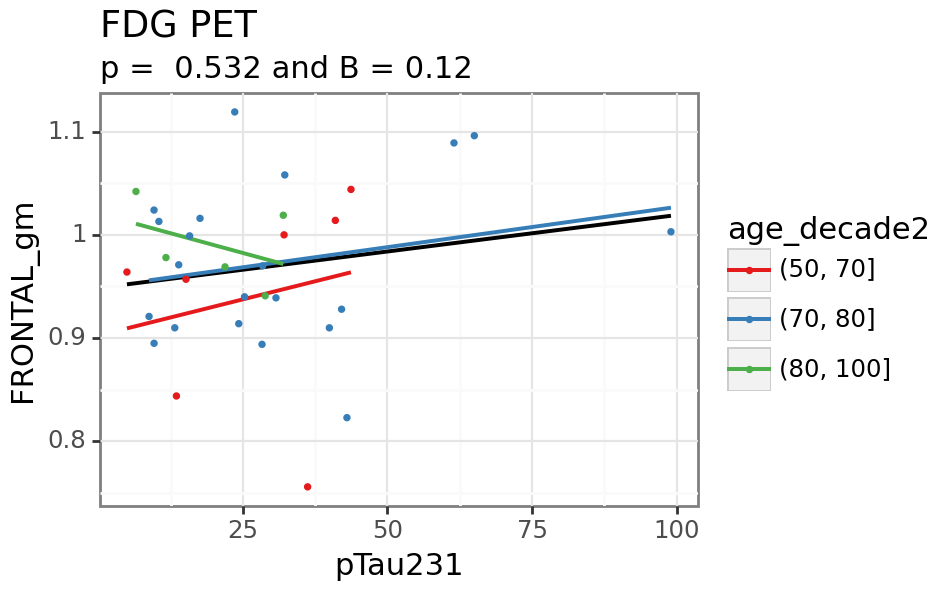

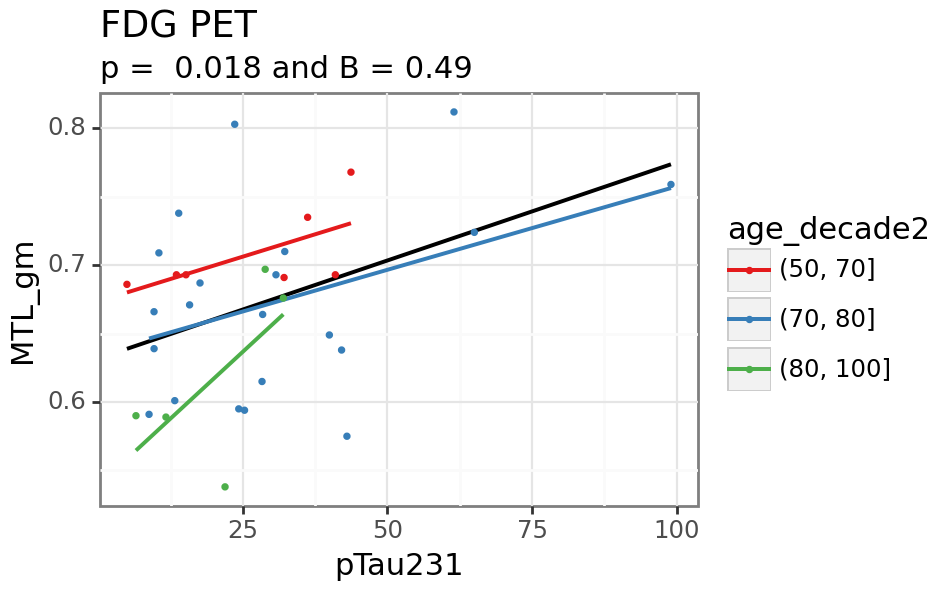

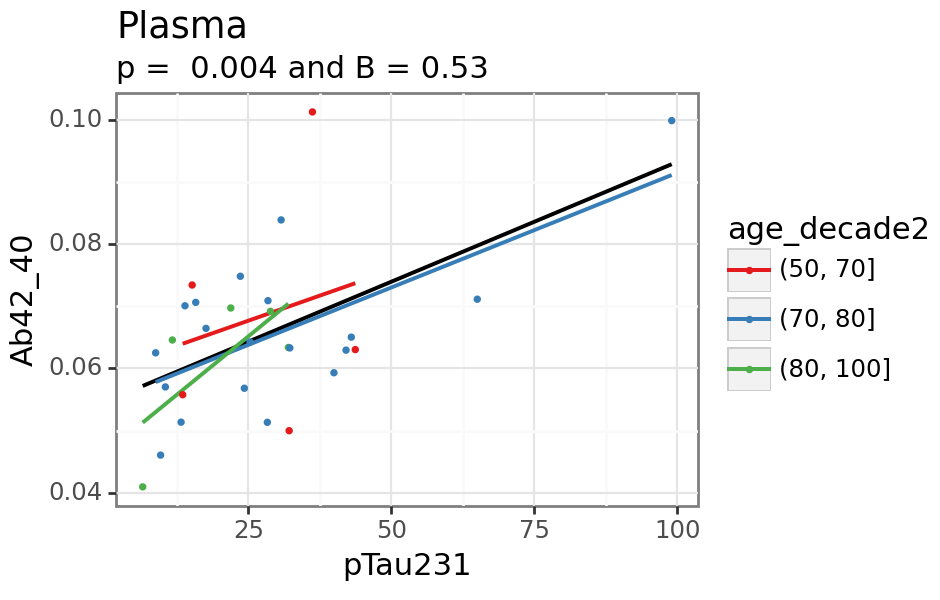

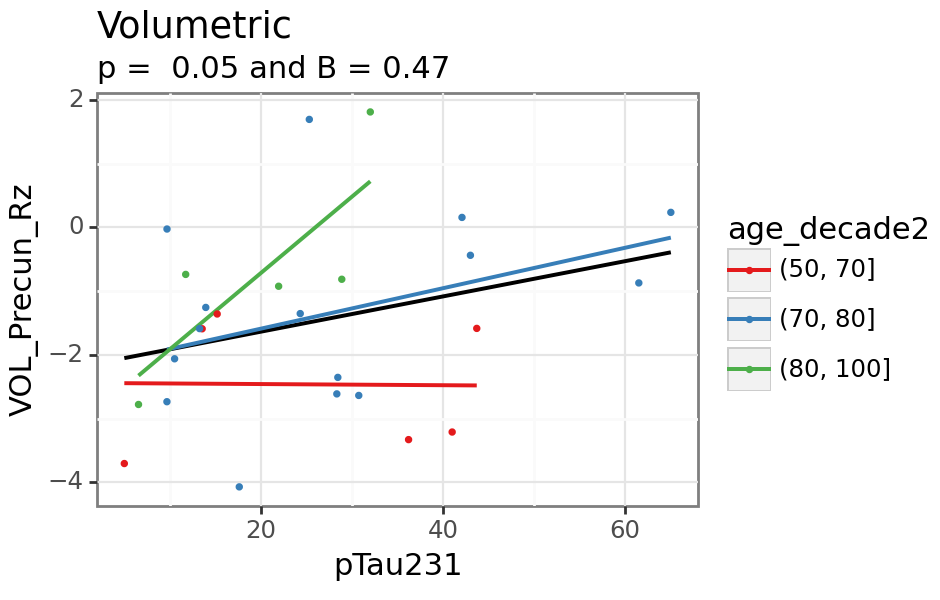

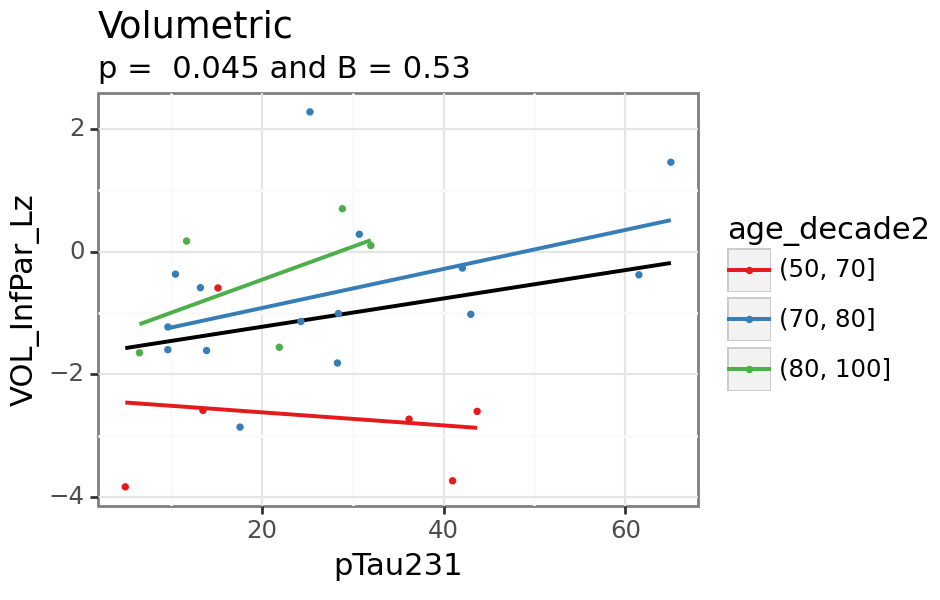

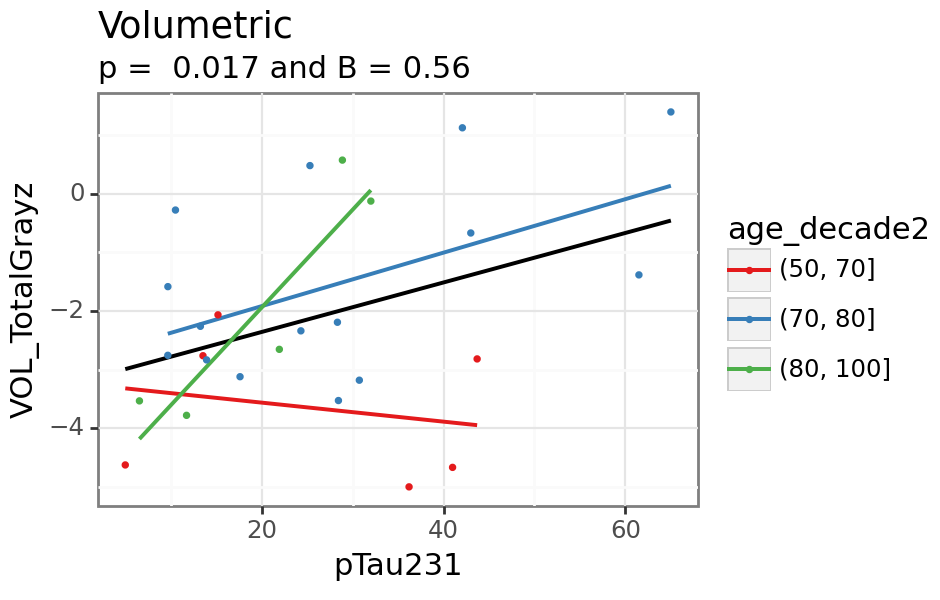

In [27]:
p9.options.figure_size = (4.7,3)    
var_list = ['pTau217', 'MTL_gm', 'Avg_PCC', 'FRONTAL_gm', 'MTL_gm', 'Ab42_40', 'VOL_Precun_Rz', 'VOL_InfPar_Lz', 'VOL_TotalGrayz']


for var1 in var_list:
    p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), pvals_to_consider[0]].reset_index(drop=True)[0].round(3).astype('str')
    B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')

    var0 = var
    subset_data = baseline_data.dropna(subset = [var0, var1])
    subset_data2 = subset_data.copy()
    subset_data2 = subset_data2.groupby('age_decade2', observed=True).filter(lambda x: x['ID_ADM'].nunique()> 4)
    plot = (
            p9.ggplot(subset_data, p9.aes(x = var0, y = var1, color = 'age_decade2'))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(subset_data, size = 0.8, se = False, alpha = 1, color = 'black', method = 'lm')
            + p9.geom_smooth(subset_data2, size = 0.8, se = False, alpha = 1, method = 'lm')
            + p9.geom_line(p9.aes(group = 'ID_ADM'), size = 0.2, linetype = '--')
            + p9.geom_point(size = 0.5)
            + p9.labs(subtitle = ('p =  ' + p_value + ' and B = ' + B_value), title = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), 'type'].reset_index(drop=True)[0])
            + p9.scale_color_brewer(type="qual", palette="Set1")
            + p9.theme()
        )
    print(plot)

# GFAP

In [28]:
var = 'GFAP'

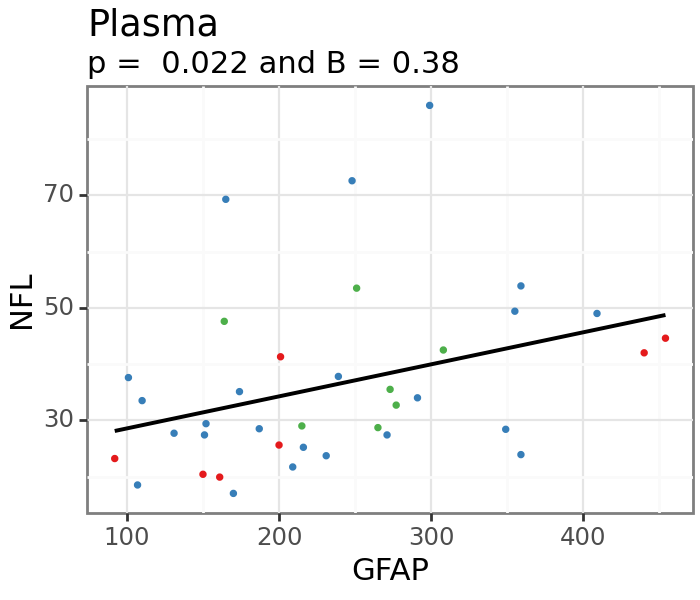

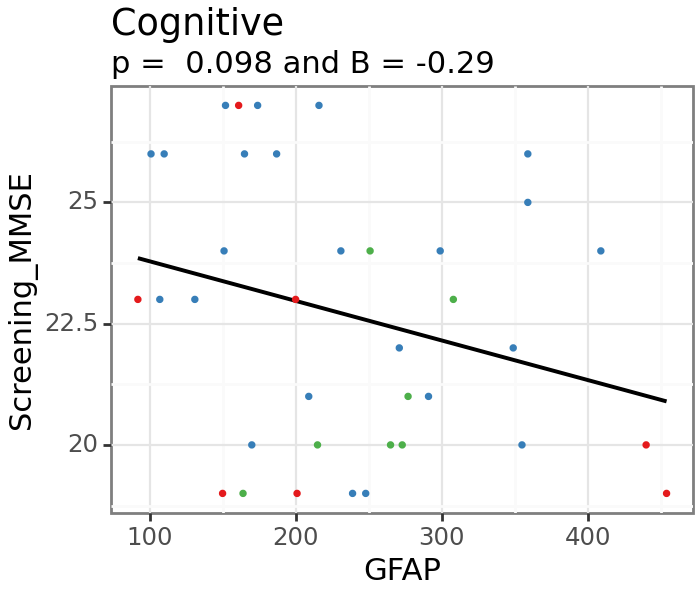

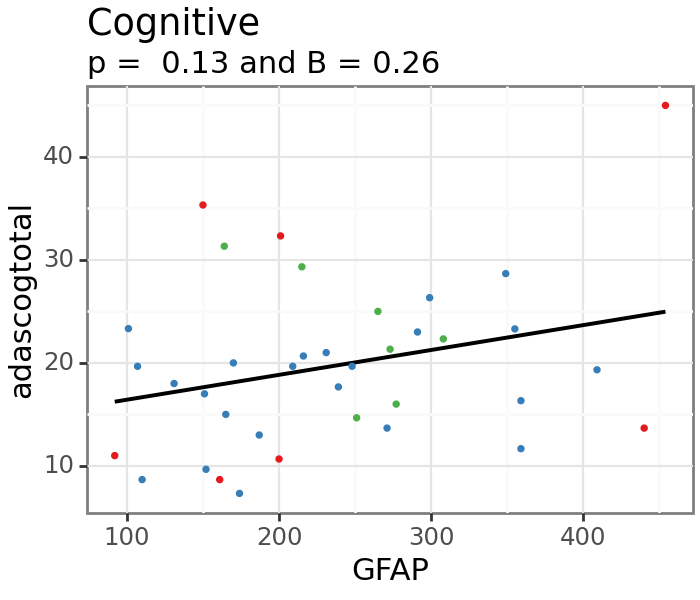

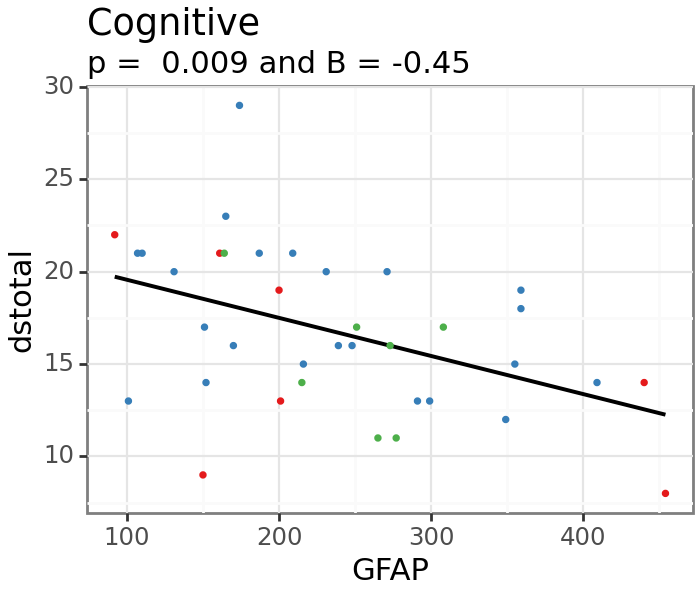

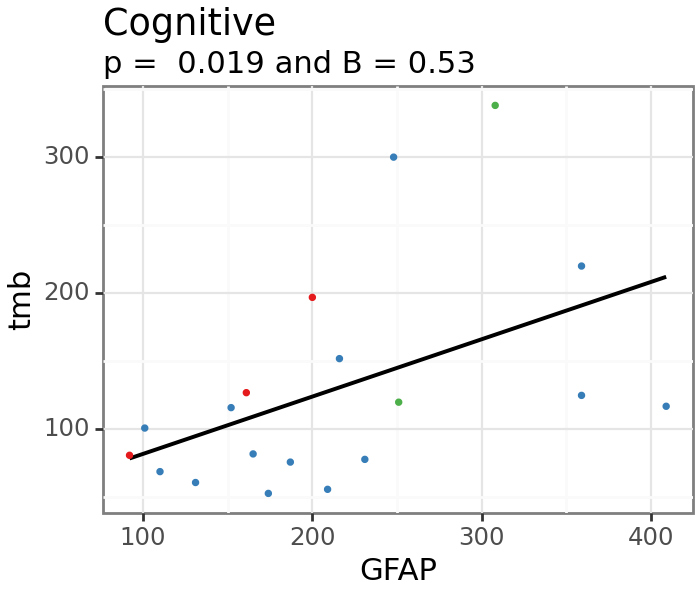

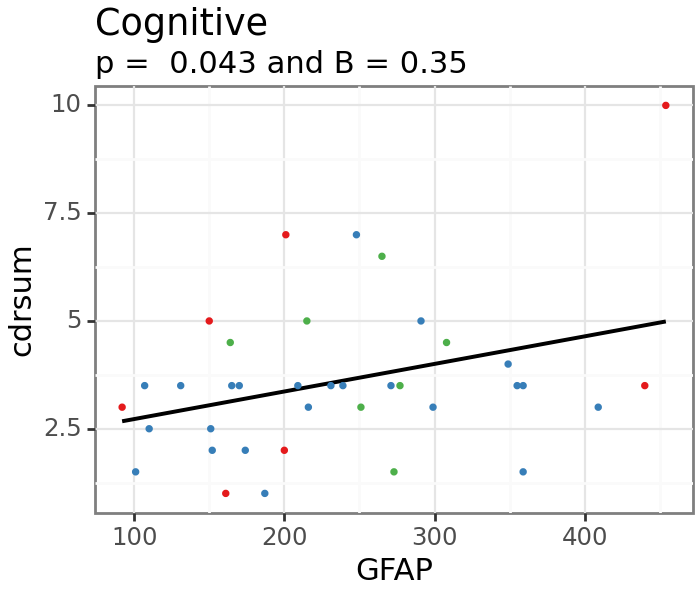

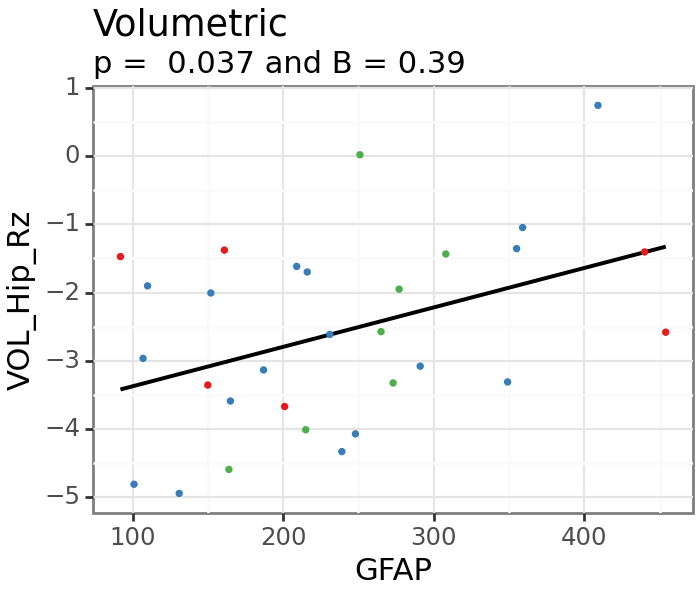

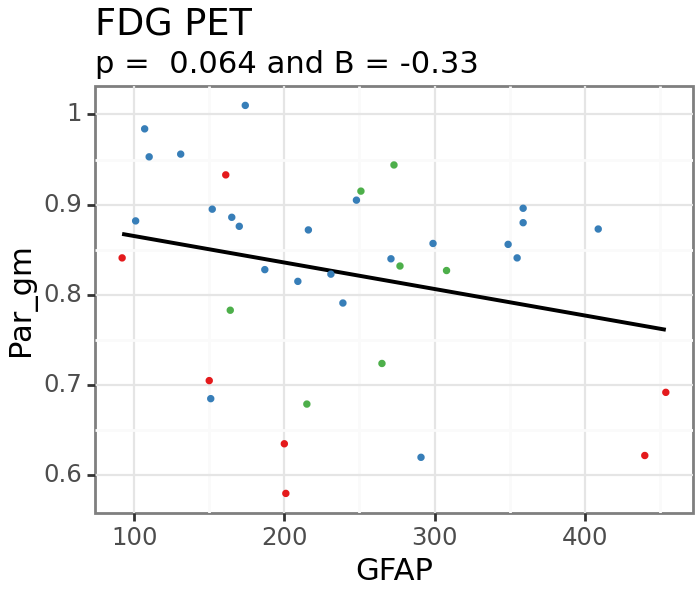

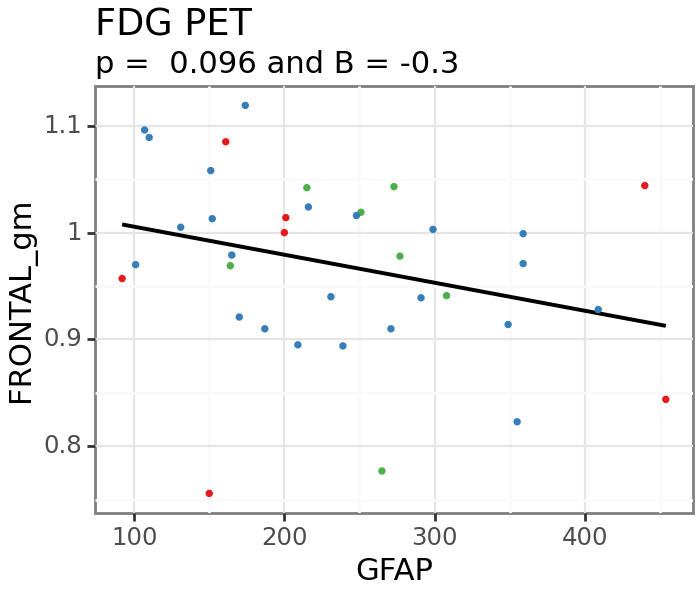

In [29]:
p9.options.figure_size = (3.5,3)    
var_list = ['NFL', 'Screening_MMSE', 'adascogtotal', 'dstotal', 'tmb', 'cdrsum', 'VOL_Hip_Rz', 'Par_gm', 'FRONTAL_gm']

for var1 in var_list:
    p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), pvals_to_consider[0]].reset_index(drop=True)[0].round(3).astype('str')
    B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')

    var0 = var
    subset_data = baseline_data.dropna(subset = [var0, var1])
    subset_data2 = subset_data.copy()
    subset_data2 = subset_data2.groupby('age_decade2', observed=True).filter(lambda x: x['ID_ADM'].nunique()> 10)
    plot = (
            p9.ggplot(subset_data, p9.aes(x = var0, y = var1, color = 'age_decade2'))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(subset_data, size = 0.8, se = False, alpha = 1, color = 'black', method = 'lm')
            #+ p9.geom_smooth(subset_data2, size = 0.8, se = False, alpha = 1)
            + p9.geom_line(p9.aes(group = 'ID_ADM'), size = 0.2, linetype = '--')
            + p9.geom_point(size = 0.5)
            + p9.labs(subtitle = ('p =  ' + p_value + ' and B = ' + B_value), title = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), 'type'].reset_index(drop=True)[0])
            + p9.scale_color_brewer(type="qual", palette="Set1")
            + p9.theme(legend_position='none')
        )
    print(plot)

# NFL

In [30]:
var = 'NFL'

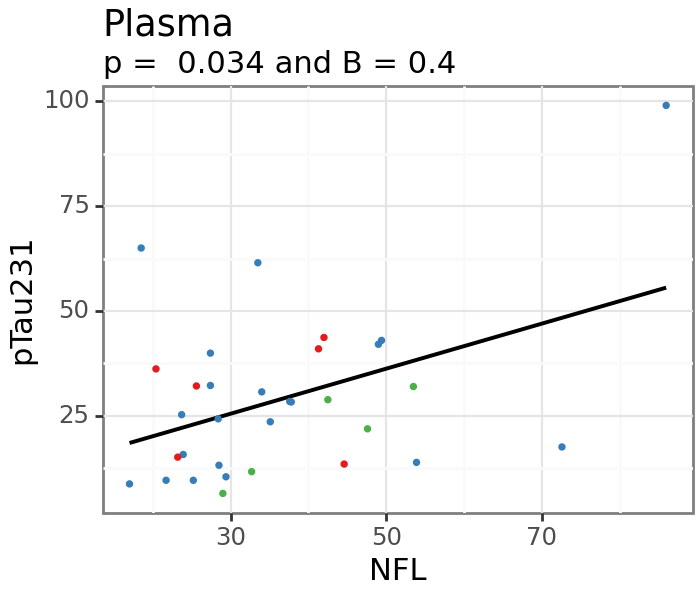

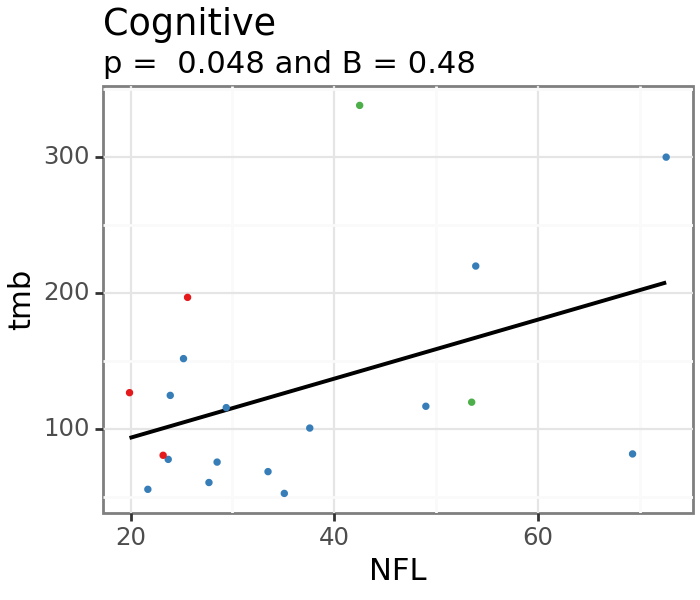

In [31]:
p9.options.figure_size = (3.5,3)    
var_list = ['pTau231', 'tmb']

for var1 in var_list:
    p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), pvals_to_consider[0]].reset_index(drop=True)[0].round(3).astype('str')
    B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')

    var0 = var
    subset_data = baseline_data.dropna(subset = [var0, var1])
    subset_data2 = subset_data.copy()
    subset_data2 = subset_data2.groupby('age_decade2', observed=True).filter(lambda x: x['ID_ADM'].nunique()> 10)
    plot = (
            p9.ggplot(subset_data, p9.aes(x = var0, y = var1, color = 'age_decade2'))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(subset_data, size = 0.8, se = False, alpha = 1, color = 'black', method = 'lm')
            #+ p9.geom_smooth(subset_data2, size = 0.8, se = False, alpha = 1)
            + p9.geom_line(p9.aes(group = 'ID_ADM'), size = 0.2, linetype = '--')
            + p9.geom_point(size = 0.5)
            + p9.labs(subtitle = ('p =  ' + p_value + ' and B = ' + B_value), title = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), 'type'].reset_index(drop=True)[0])
            + p9.scale_color_brewer(type="qual", palette="Set1")
            + p9.theme(legend_position='none')
        )
    print(plot)

# Ab40

In [32]:
var = 'Ab40'

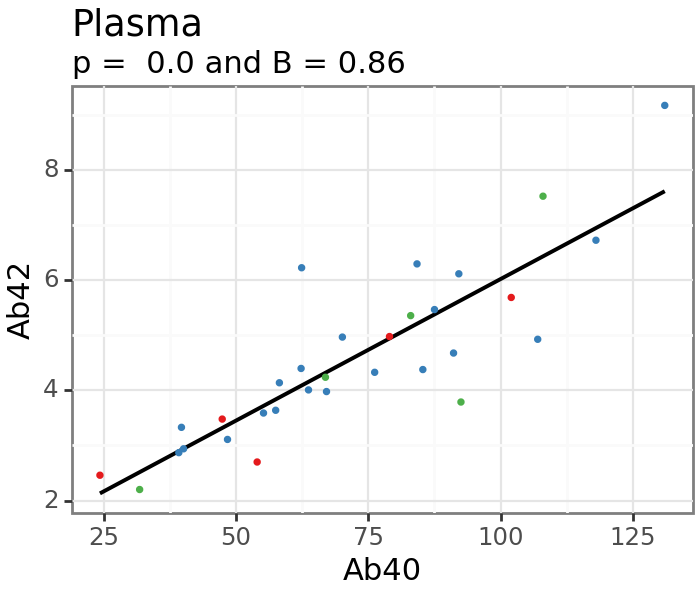

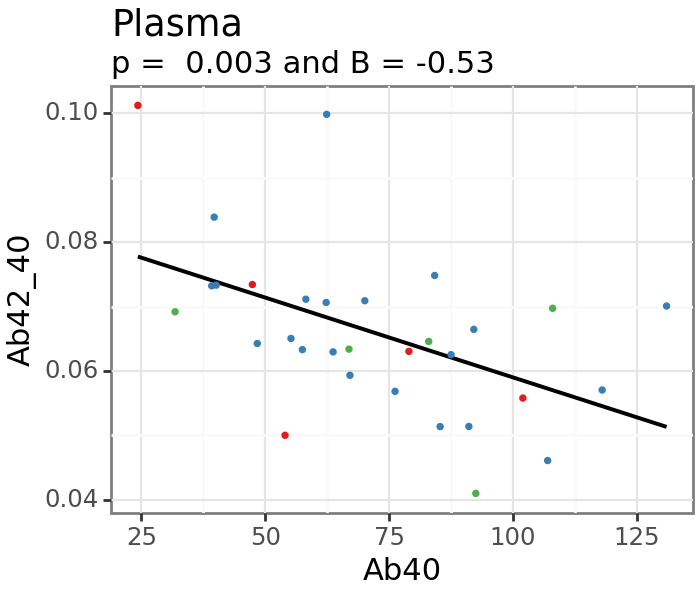

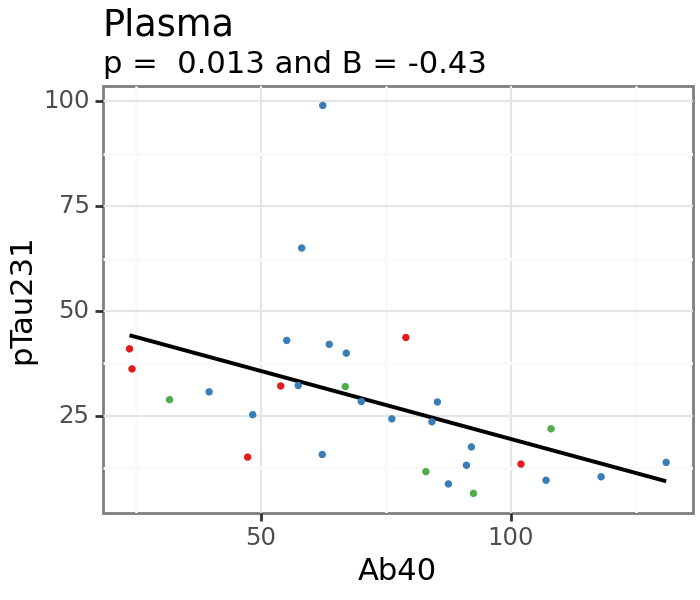

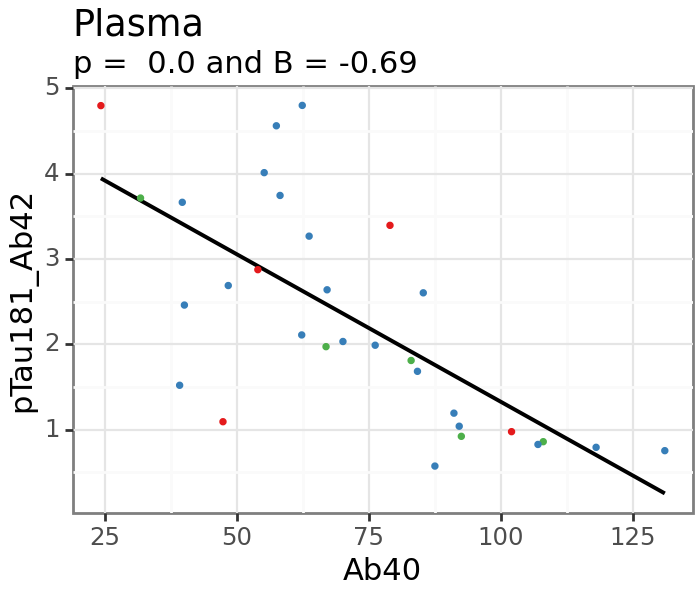

In [33]:
p9.options.figure_size = (3.5,3)    
var_list = ['Ab42', 'Ab42_40', 'pTau231', 'pTau181_Ab42']

for var1 in var_list:
    p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), pvals_to_consider[0]].reset_index(drop=True)[0].round(3).astype('str')
    B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')

    var0 = var
    subset_data = baseline_data.dropna(subset = [var0, var1])
    subset_data2 = subset_data.copy()
    subset_data2 = subset_data2.groupby('age_decade2', observed=True).filter(lambda x: x['ID_ADM'].nunique()> 10)
    plot = (
            p9.ggplot(subset_data, p9.aes(x = var0, y = var1, color = 'age_decade2'))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(subset_data, size = 0.8, se = False, alpha = 1, color = 'black', method = 'lm')
            #+ p9.geom_smooth(subset_data2, size = 0.8, se = False, alpha = 1)
            + p9.geom_line(p9.aes(group = 'ID_ADM'), size = 0.2, linetype = '--')
            + p9.geom_point(size = 0.5)
            + p9.labs(subtitle = ('p =  ' + p_value + ' and B = ' + B_value), title = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), 'type'].reset_index(drop=True)[0])
            + p9.scale_color_brewer(type="qual", palette="Set1")
            + p9.theme(legend_position='none')
        )
    print(plot)

# Ab42

In [34]:
var = 'Ab42'

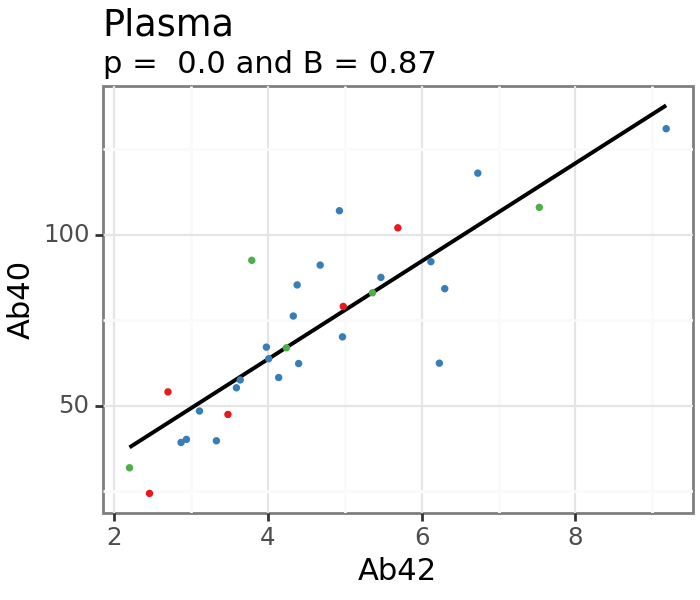

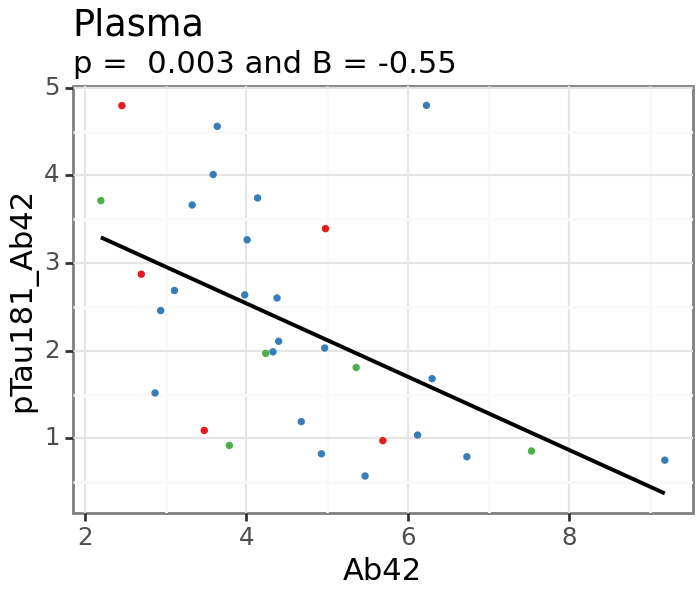

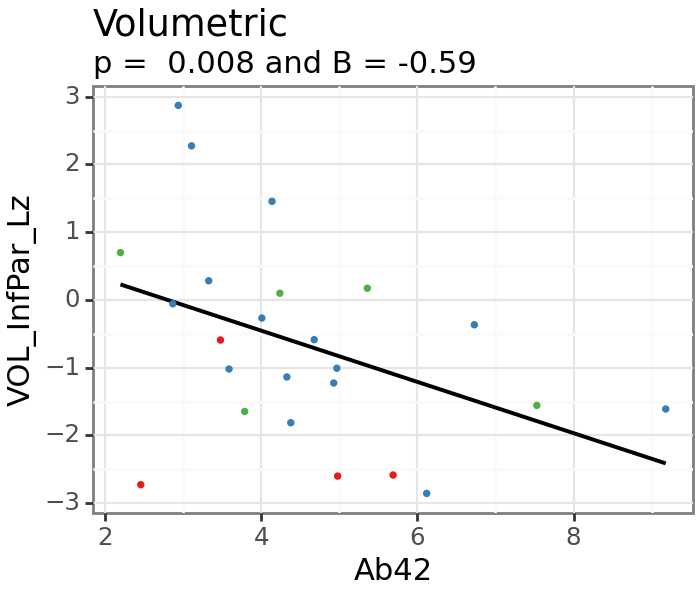

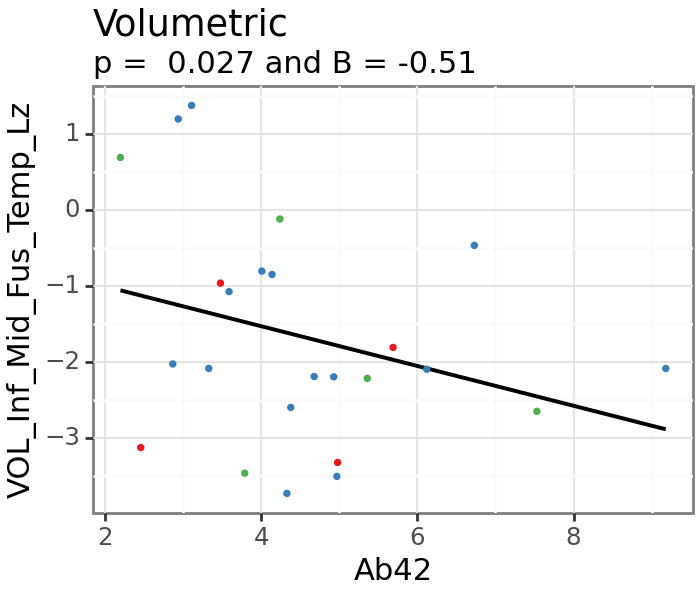

In [35]:
p9.options.figure_size = (3.5,3)    
var_list = ['Ab40', 'pTau181_Ab42', 'VOL_InfPar_Lz', 'VOL_Inf_Mid_Fus_Temp_Lz']

for var1 in var_list:
    p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), pvals_to_consider[0]].reset_index(drop=True)[0].round(3).astype('str')
    B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')
    
    var0 = var
    subset_data = baseline_data.dropna(subset = [var0, var1])
    subset_data2 = subset_data.copy()
    subset_data2 = subset_data2.groupby('age_decade2', observed=True).filter(lambda x: x['ID_ADM'].nunique()> 10)
    plot = (
            p9.ggplot(subset_data, p9.aes(x = var0, y = var1, color = 'age_decade2'))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(subset_data, size = 0.8, se = False, alpha = 1, color = 'black', method = 'lm')
            #+ p9.geom_smooth(subset_data2, size = 0.8, se = False, alpha = 1)
            + p9.geom_line(p9.aes(group = 'ID_ADM'), size = 0.2, linetype = '--')
            + p9.geom_point(size = 0.5)
            + p9.labs(subtitle = ('p =  ' + p_value + ' and B = ' + B_value), title = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), 'type'].reset_index(drop=True)[0])
            + p9.scale_color_brewer(type="qual", palette="Set1")
            + p9.theme(legend_position='none')
        )
    print(plot)

# Ab42_40

In [36]:
var = 'Ab42_40'

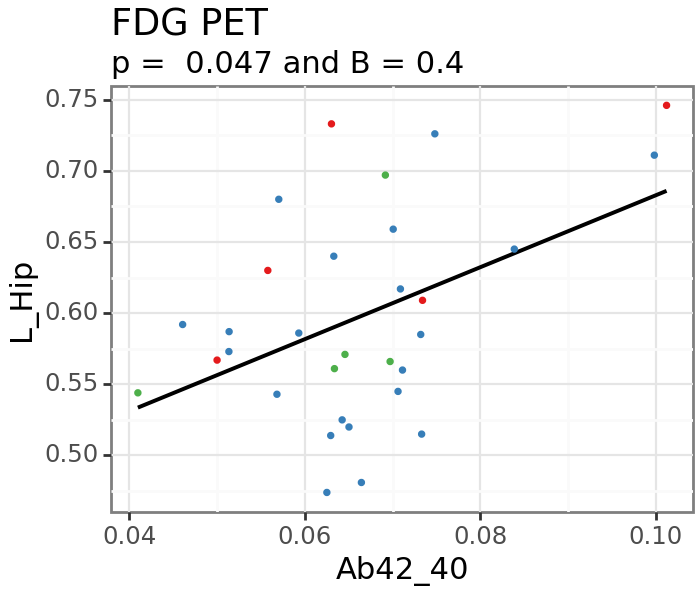

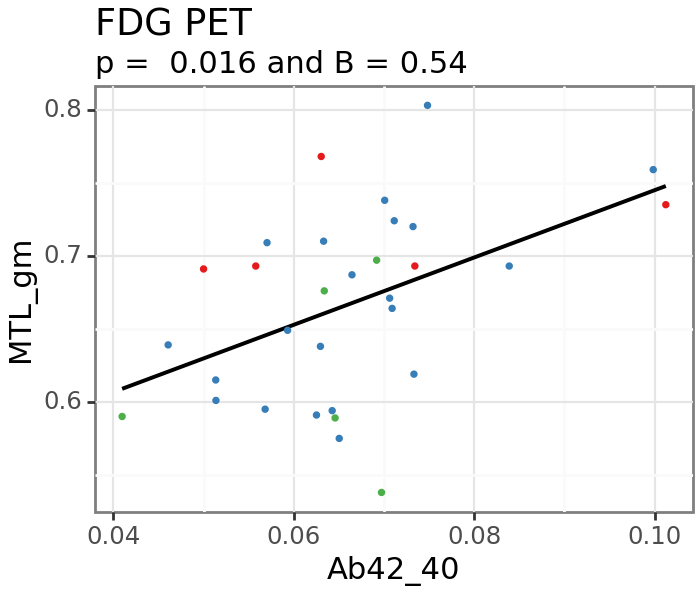

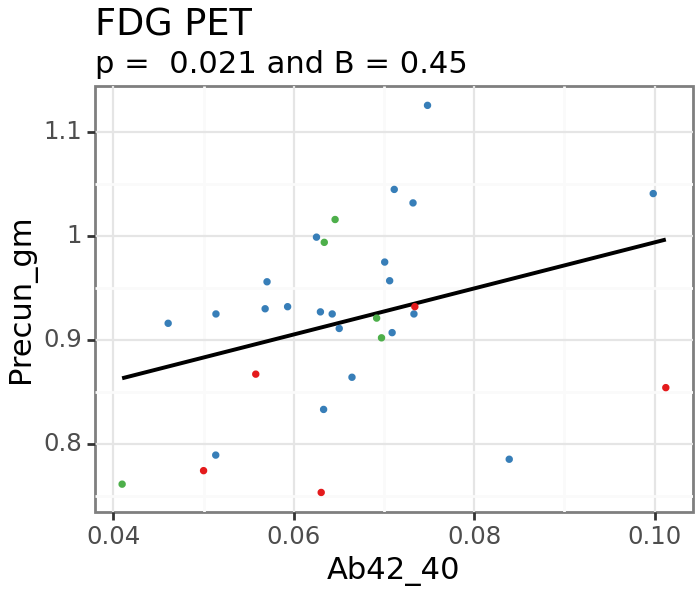

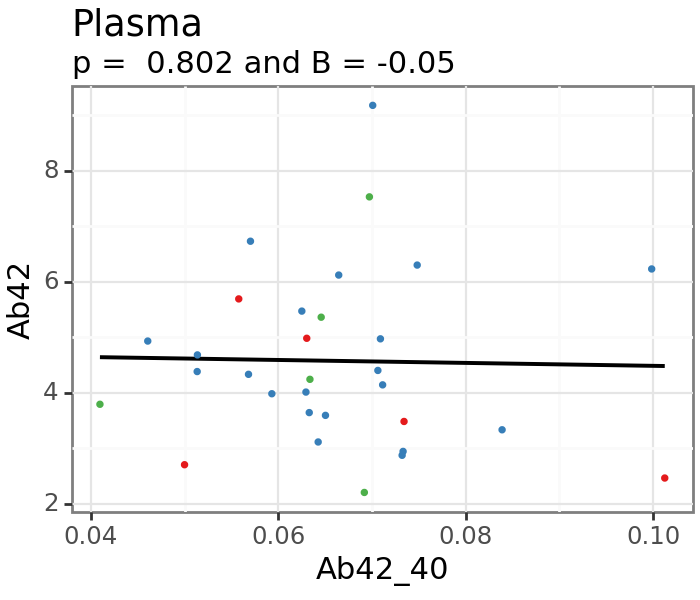

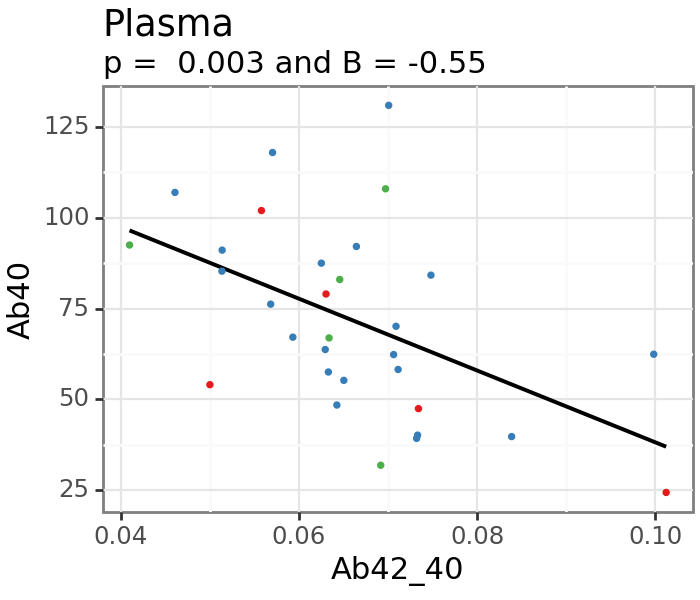

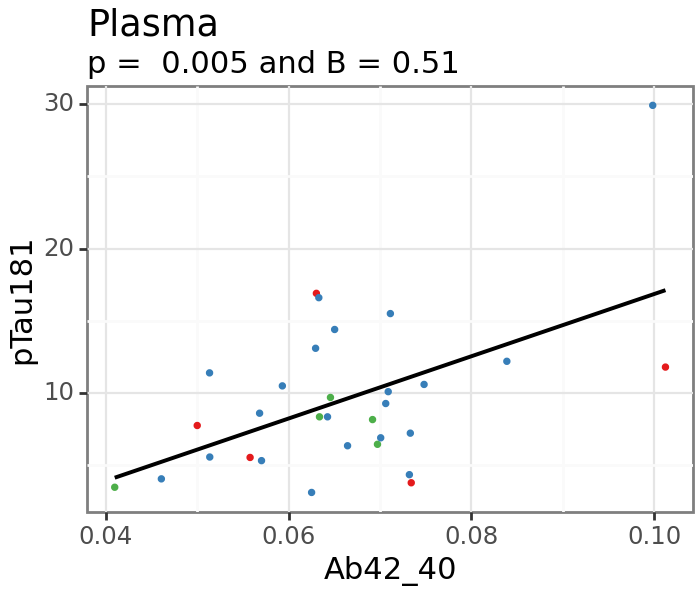

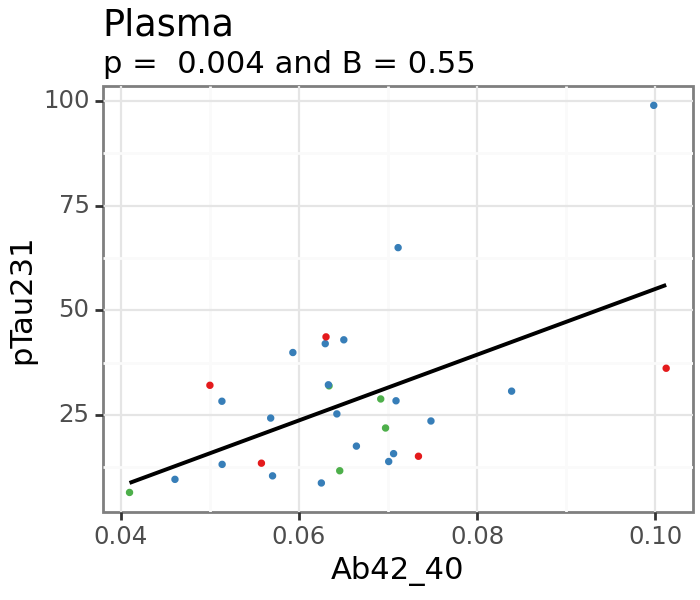

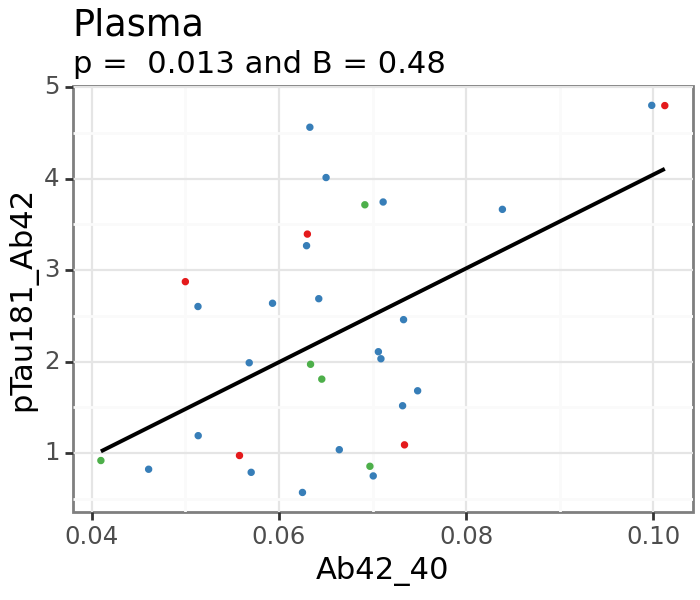

In [37]:
p9.options.figure_size = (3.5,3)    
var_list = ['L_Hip', 'MTL_gm', 'Precun_gm', 'Ab42', 'Ab40', 'pTau181', 'pTau231', 'pTau181_Ab42']

for var1 in var_list:
    p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), pvals_to_consider[0]].reset_index(drop=True)[0].round(3).astype('str')
    B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')

    var0 = var
    subset_data = baseline_data.dropna(subset = [var0, var1])
    subset_data2 = subset_data.copy()
    subset_data2 = subset_data2.groupby('age_decade2', observed=True).filter(lambda x: x['ID_ADM'].nunique()> 10)
    plot = (
            p9.ggplot(subset_data, p9.aes(x = var0, y = var1, color = 'age_decade2'))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(subset_data, size = 0.8, se = False, alpha = 1, color = 'black', method = 'lm')
            #+ p9.geom_smooth(subset_data2, size = 0.8, se = False, alpha = 1)
            + p9.geom_line(p9.aes(group = 'ID_ADM'), size = 0.2, linetype = '--')
            + p9.geom_point(size = 0.5)
            + p9.labs(subtitle = ('p =  ' + p_value + ' and B = ' + B_value), title = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), 'type'].reset_index(drop=True)[0])
            + p9.scale_color_brewer(type="qual", palette="Set1")
            + p9.theme(legend_position='none')
        )
    print(plot)

# pTau181_Ab42

In [38]:
var = 'pTau181_Ab42'

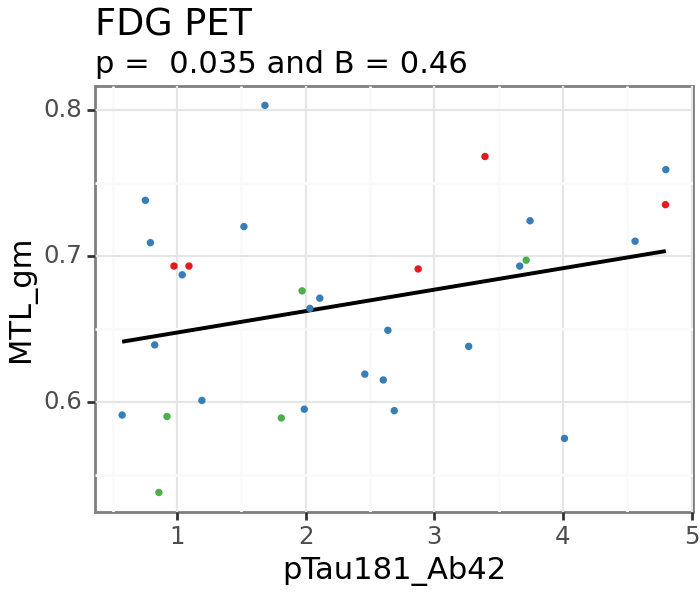

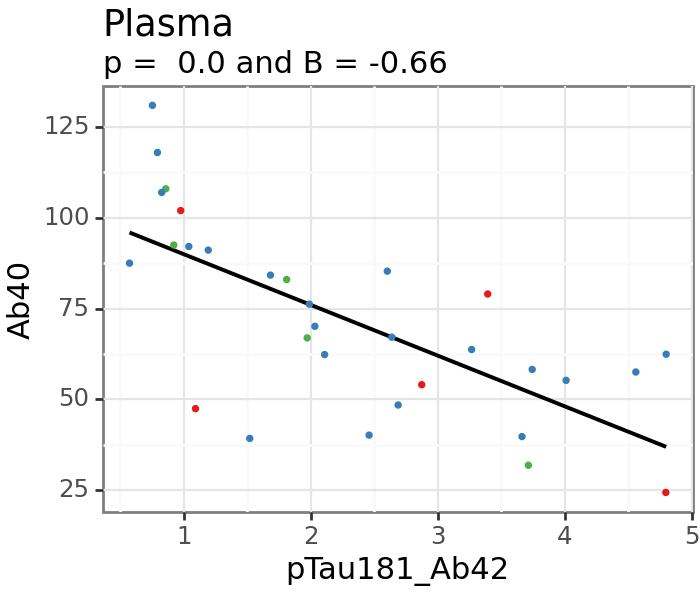

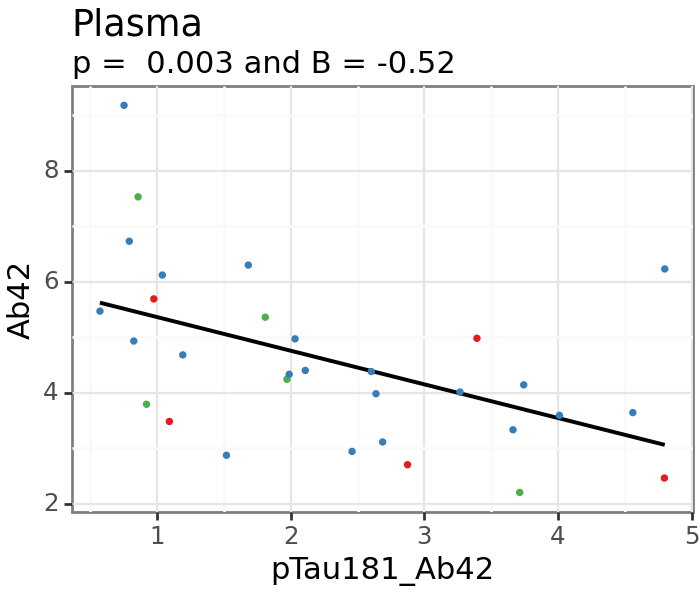

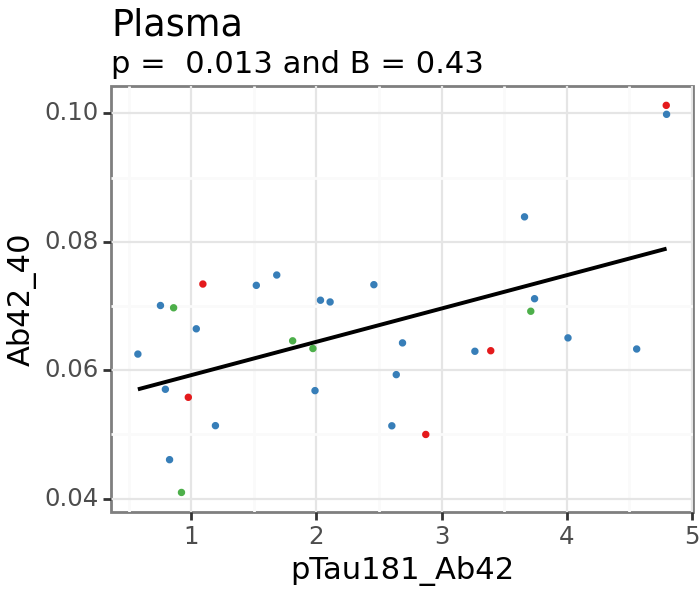

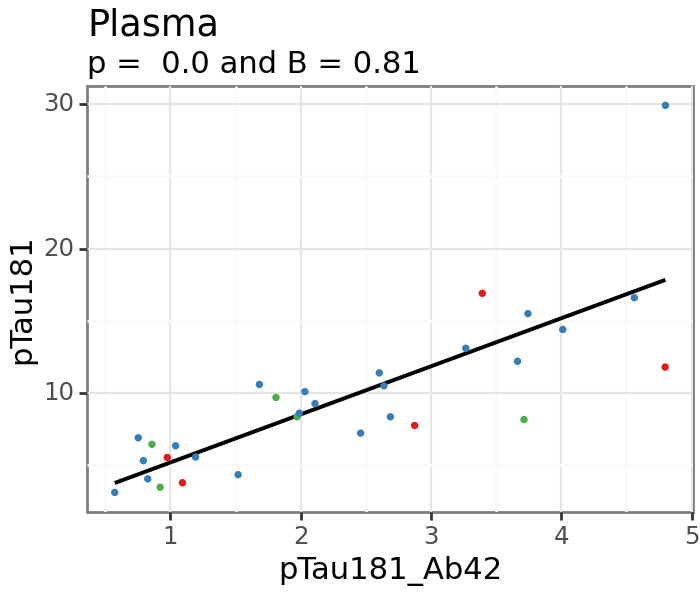

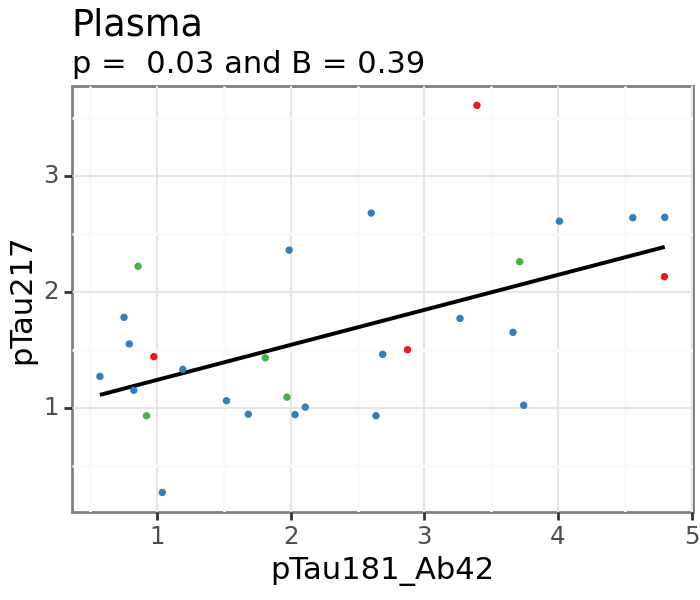

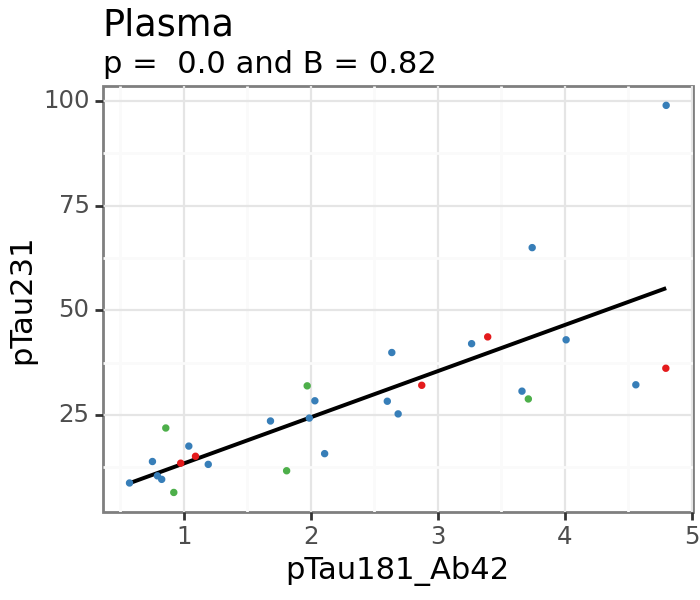

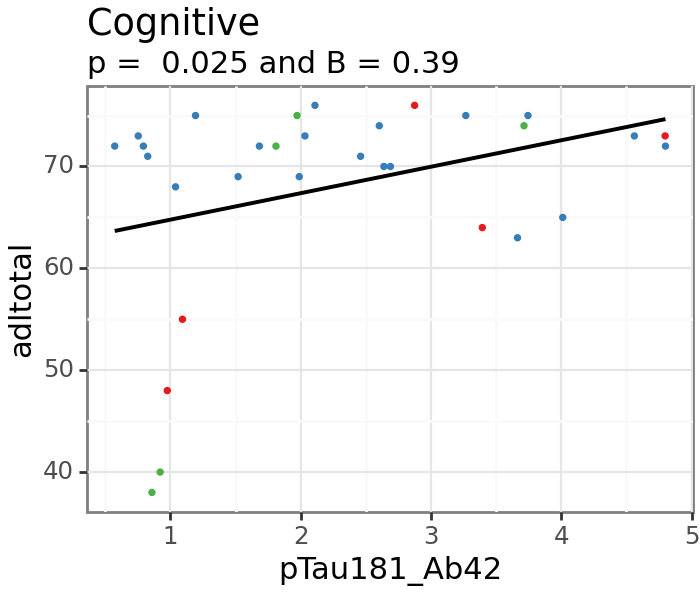

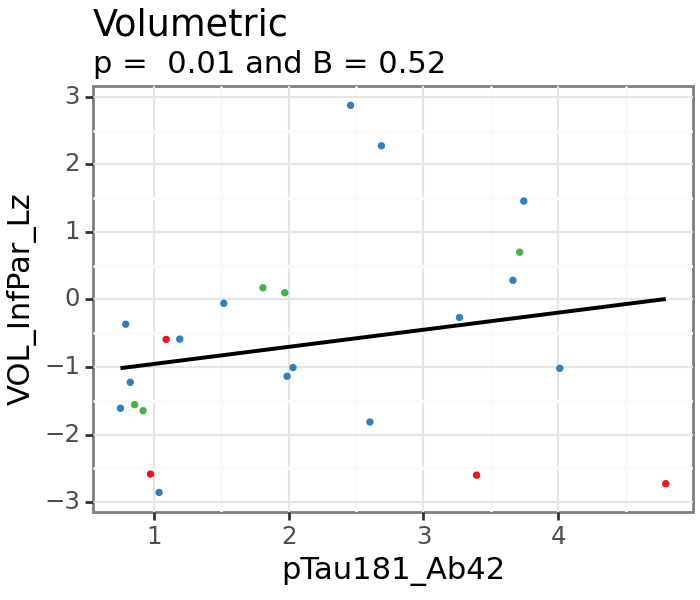

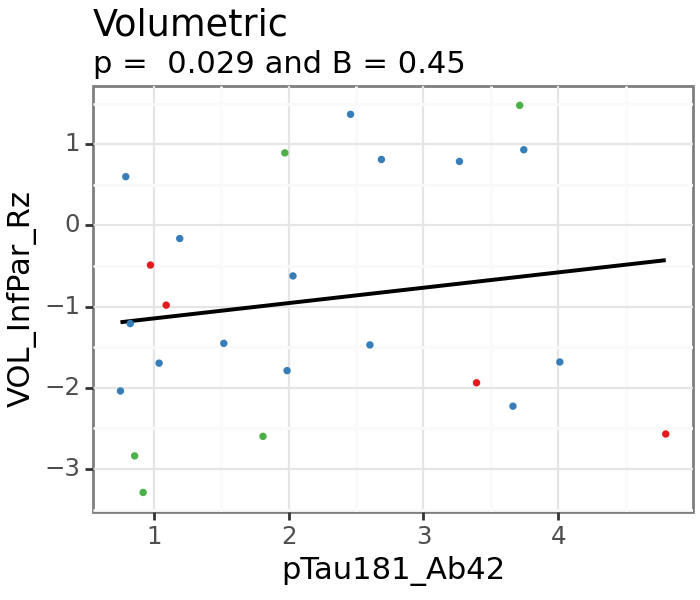

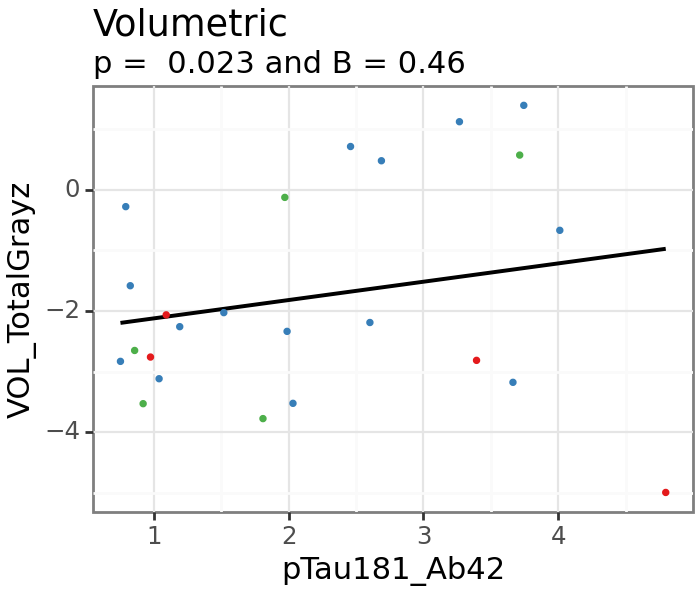

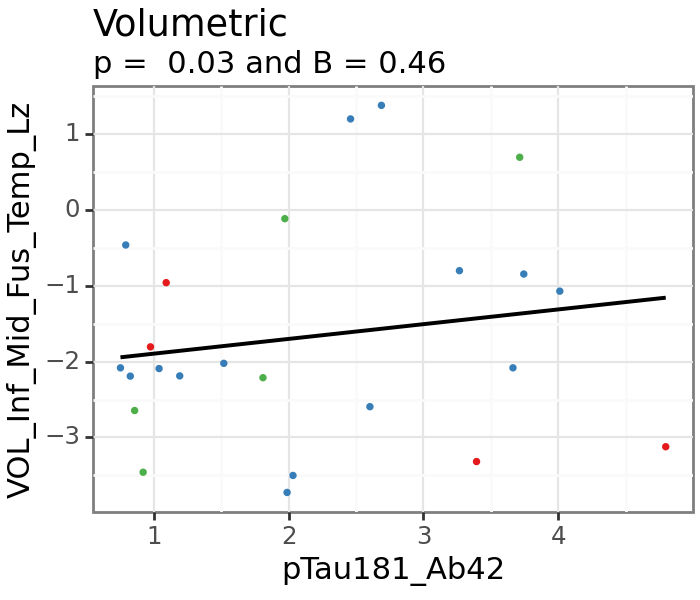

In [39]:
p9.options.figure_size = (3.5,3)    
var_list = biomarker_relationship_results_log10.loc[
    biomarker_relationship_results_log10['var1'].isin([var]) & (biomarker_relationship_results_log10[pvals_to_consider].min(axis = 1)<0.05), 
    'var2']
for var1 in var_list.to_list():
    p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), pvals_to_consider[0]].reset_index(drop=True)[0].round(3).astype('str')
    B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')

    var0 = var
    subset_data = baseline_data.dropna(subset = [var0, var1])
    subset_data2 = subset_data.copy()
    subset_data2 = subset_data2.groupby('age_decade2', observed=True).filter(lambda x: x['ID_ADM'].nunique()> 10)
    plot = (
            p9.ggplot(subset_data, p9.aes(x = var0, y = var1, color = 'age_decade2'))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(subset_data, size = 0.8, se = False, alpha = 1, color = 'black', method = 'lm')
            #+ p9.geom_smooth(subset_data2, size = 0.8, se = False, alpha = 1)
            + p9.geom_line(p9.aes(group = 'ID_ADM'), size = 0.2, linetype = '--')
            + p9.geom_point(size = 0.5)
            + p9.labs(subtitle = ('p =  ' + p_value + ' and B = ' + B_value), title = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var]) & biomarker_relationship_results_log10['var2'].isin([var1]), 'type'].reset_index(drop=True)[0])
            + p9.scale_color_brewer(type="qual", palette="Set1")
            + p9.theme(legend_position='none')
        )
    print(plot)